We have, in some sense, a matrix of source-finding: we have two source-finders (and two configurations for PyBDSF) and lots of ways we can input to them. Let's try and fill that matrix in with catalogues, and then we can compare these catalogues.

The matrix is a nice summary:

| Input \ Source-finder | Aegean | PyBDSF (Shane) | PyBDSF (LOFAR) |
|-----------------------|--------|--------||
| Average $I$ | | ||
| Average $P$ | | ||
| First-moment $Q$ and $U$ from RM-synthesis | — | ||
| Average peak intensity from RM-synthesis | | ||

(Shane) and (LOFAR) are the suggested configurations from Shane and the LOFAR survey team respectively.

In [1]:
import logging
import os.path

import numpy
import matplotlib.pyplot as plt
from AegeanTools import BANE
from AegeanTools.catalogs import check_table_formats, save_catalog, show_formats
from AegeanTools.source_finder import SourceFinder, get_aux_files
import astropy.io.fits as fits
from multiprocessing.pool import Pool
from astropy.convolution import convolve, Gaussian2DKernel
from tqdm import tqdm_notebook as tqdm
import bdsf
import pandas
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord as SC
import scipy.fftpack

In [2]:
import astropy.visualization as vis

stretch = vis.AsinhStretch(0.1) + vis.MinMaxInterval()

In [3]:
def bdsf_show_fit(img_mP, ch0_flagged=False):
    import matplotlib.cm as cm
    from matplotlib.patches import Ellipse
    import bdsf.plotresults
    bdsf.plotresults.has_pl = True
    bdsf.plotresults.pl = plt
    bdsf.plotresults.cm = cm
    bdsf.plotresults.Ellipse = Ellipse
    bdsf.plotresults.collections = __import__('matplotlib').collections
    bdsf.plotresults.plotresults(img_mP, ch0_flagged=ch0_flagged)
    plt.show()

# Average I

We first need to actually compute the average $I$. This requires smoothing to a common resolution over the frequencies.

In [4]:
beam = '04'

In [5]:
Q = fits.open(f'/data/mash/alger/image.restored.q.SB8583.contcube.RACS_test4_1.05_0538-31A.beam{beam}.fits',
              mode='denywrite')
U = fits.open(f'/data/mash/alger/image.restored.u.SB8583.contcube.RACS_test4_1.05_0538-31A.beam{beam}.fits',
              mode='denywrite')
I = fits.open(f'/data/mash/alger/image.restored.i.SB8583.contcube.RACS_test4_1.05_0538-31A.beam{beam}.fits',
              mode='denywrite')

In [6]:
# From gheald/quocka
def smoothloop(args):
    data, head, freq, freq_r = args
    if freq == freq_r:
        return data
    freq_r = head['CRVAL4']
    bmaj = head['BMAJ'] * (freq_r) / freq
    bmin = head['BMIN'] * (freq_r) / freq
    pa = numpy.deg2rad(head['BPA'])
    conv_width_maj = numpy.sqrt(head['BMAJ'] ** 2 - bmaj ** 2)  # arcmin
    conv_width_min = numpy.sqrt(head['BMIN'] ** 2 - bmin ** 2)  # arcmin
    px_scale = abs(head['CDELT1'])
    sig_min = conv_width_min / (2 * numpy.sqrt(2 * numpy.log(2))) / px_scale
    sig_maj = conv_width_maj / (2 * numpy.sqrt(2 * numpy.log(2))) / px_scale
    g = Gaussian2DKernel(
        sig_min,
        sig_maj,
        theta=pa)
    data = convolve(data, g, boundary='extend') * (2 * numpy.pi * sig_min * sig_maj)
    return data

In [7]:
def smooth_cube(cube):
    data = cube[0].data
    head = cube[0].header
    data = data[:, 0, :, :]
    n_channels = len(data)
    freqs = numpy.arange(head['CRVAL4'], head['CRVAL4'] + head['CDELT4'] * n_channels, head['CDELT4'])
    assert len(freqs) == n_channels
    args = [[channel, head, freq, head['CRVAL4']] for channel, freq in zip(data, freqs)]
    with Pool(8) as pool:
        output = pool.imap(smoothloop, args)
        output = [i for i in tqdm(output, total=len(args))]
    return output

In [8]:
resmooth = False

smoothed_path = f'/home/alger/possum/alger/hamburg/I_{beam}.smoothed.mean.fits'

if resmooth:
    smoothed_I = smooth_cube(I)
    # Once smoothed we can compute the mean.
    total_I_header = I[0].header.copy()
    total_I_header['NAXIS3'] = 0
    total_I_header['NAXIS4'] = 0
    total_I = numpy.mean(smoothed_I, axis=0)
    total_I_fits = fits.PrimaryHDU(data=total_I[:, :], header=total_I_header)
    total_I_fits.writeto(smoothed_path, overwrite=True)
else:
    total_I_fits = fits.open(smoothed_path, mode='denywrite')
    total_I = total_I_fits[0].data

## Aegean

We'll just use default parameters. First we run BANE to find the background noise and RMS.

In [9]:
BANE.filter_image(smoothed_path, smoothed_path, cores=8)

ERROR:root:Caught keyboard interrupt
Process ForkPoolWorker-3:


SystemExit: 1

Process ForkPoolWorker-7:
Process ForkPoolWorker-4:
Process ForkPoolWorker-1:
Process ForkPoolWorker-6:
Process ForkPoolWorker-8:
Process ForkPoolWorker-2:
/home/alger/mimsy/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
Traceback (most recent call last):
  File "/home/alger/mimsy/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/alger/mimsy/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/alger/mimsy/conda/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/alger/mimsy/conda/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/home/alger/mimsy/conda/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = se

In [24]:
%%bash
ls /home/alger/possum/alger/hamburg/I_04.smoothed.mean*

/home/alger/possum/alger/hamburg/I_04.smoothed.mean.fits
/home/alger/possum/alger/hamburg/I_04.smoothed.mean.fits_bkg.fits
/home/alger/possum/alger/hamburg/I_04.smoothed.mean.fits_rms.fits


Then we can run the source finder itself. This returns a list of sources rather than a catalogue, though we can convert between the two.

In [303]:
# Hacked from AegeanTools/scripts/Aegean.
csv_path = f'/home/alger/possum/alger/hamburg/I_{beam}.smoothed.mean.csv'
log = logging.getLogger("Aegean")
log.setLevel(logging.INFO)
sf = SourceFinder(log=log)
cores = 1
filename = smoothed_path
hdu_index = 0
lat = -26.6970
basename = os.path.splitext(filename)[0]
backgroundimg = '/home/alger/possum/alger/hamburg/I_04.smoothed.mean.fits_bkg.fits'
noiseimg = '/home/alger/possum/alger/hamburg/I_04.smoothed.mean.fits_rms.fits'
tables = csv_path
if not check_table_formats(tables):
    log.critical("One or more output table formats are not supported: Exiting")
    print(show_formats())
    raise ValueError()

log.info("Finding sources.")
found = sf.find_sources_in_image(filename, hdu_index=hdu_index, cores=cores, rmsin=noiseimg,
                                 bkgin=backgroundimg,
                                 doislandflux=True,
                                 nonegative=False, nopositive=False,
                                 lat=lat)

sources = sf.sources
log.info("found {0} sources total".format(len(sources)))
if len(sources) > 0 and tables:
    for t in tables.split(','):
        save_catalog(t, sources)

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not

We can use the islands to obtain masked cutouts of the $P$ image.

In [29]:
aegean_islands = pandas.read_csv('/home/alger/possum/alger/hamburg/I_04.smoothed.mean_isle.csv')
aegean_components = pandas.read_csv('/home/alger/possum/alger/hamburg/I_04.smoothed.mean_comp.csv')

In [30]:
len(aegean_islands), len(aegean_components)

(218, 245)

In [305]:
wcs = WCS(I[0].header).dropaxis(3).dropaxis(2)

In [306]:
aegean_polarised_cutouts = []
for i, island in tqdm(aegean_islands.iterrows(), total=len(aegean_islands)):
    ra, dec = island.ra, island.dec
    (y, x), = wcs.all_world2pix([[ra, dec]], 1).astype(int)
    xr = max(island.x_width // 2, 6)  # Particularly small widths tend to be wrong.
    yr = max(island.y_width // 2, 6)
    bbox = (slice(None, None), 0, slice(x - xr, x + xr), slice(y - yr, y + yr))
    cutout_Q = Q[0].data[bbox]
    cutout_U = U[0].data[bbox]
    aegean_polarised_cutouts.append(cutout_Q + 1j * cutout_U)

In [307]:
aegean_intensity_cutouts = []
for i, island in tqdm(aegean_islands.iterrows(), total=len(aegean_islands)):
    ra, dec = island.ra, island.dec
    (y, x), = wcs.all_world2pix([[ra, dec]], 1).astype(int)
    xr = max(island.x_width // 2, 6)
    yr = max(island.y_width // 2, 6)
    bbox = (slice(x - xr, x + xr), slice(y - yr, y + yr))
    cutout = total_I[bbox]
    aegean_intensity_cutouts.append(cutout)

Now we can generate polarised spectra for each image. I'm going to do this really naïvely to begin with, and not mask at all. We'll just assume the whole image is the one object.

In [12]:
aegean_polarised_spectra = numpy.array([numpy.sum(c, axis=(1, 2)) for c in aegean_polarised_cutouts]) # Jy/beam
aegean_polarised_spectra *= aegean_islands.beam_area.values[:, None]  # Jy/beam -> Jy

In [13]:
aegean_polarised_flux = numpy.mean(abs(aegean_polarised_spectra + aegean_islands.background[:, None] + 1j * aegean_islands.background[:, None]), axis=1)

(array([56., 49., 41., 34., 17.,  9.,  6.,  3.,  2.,  1.]),
 array([4.67643118e-06, 7.70908786e-04, 1.53714114e-03, 2.30337350e-03,
        3.06960585e-03, 3.83583821e-03, 4.60207056e-03, 5.36830292e-03,
        6.13453527e-03, 6.90076763e-03, 7.66699998e-03]),
 <a list of 10 Patch objects>)

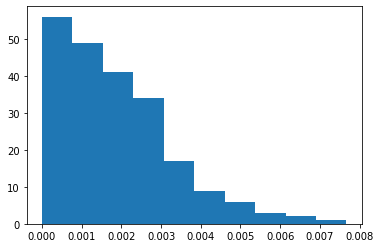

In [14]:
plt.hist(aegean_polarised_flux)

In [15]:
aegean_p_fraction = (aegean_polarised_flux / aegean_islands.int_flux)

In [302]:
for cutout_i, cutout_p, (_, isl) in zip(
        aegean_intensity_cutouts[:10], aegean_polarised_cutouts, aegean_islands.iterrows()):
    mask = cutout_i > isl.local_rms * 4
    plt.subplot(1, 2, 1)
    plt.imshow(numpy.where(mask, cutout_i, numpy.nan))
    plt.title('I')
    plt.subplot(1, 2, 2)
    plt.imshow(numpy.where(mask, abs(cutout_p).mean(axis=0), numpy.nan))
    plt.title('P')
    plt.show()

NameError: name 'aegean_intensity_cutouts' is not defined

## PyBDSF

Now let's run PyBDSF on the same image.

In [93]:
img_mP_I = bdsf.process_image(
    smoothed_path,
    rms_box=(100, 20),
    thresh='hard',
    thresh_isl=3.0,
    thresh_pix=5.0)

--> Opened '/home/alger/possum/alger/hamburg/I_04.smoothed.mean.fits'
Image size .............................. : (4096, 4096) pixels
Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (5.91619e-03, 4.38077e-03, -0.7) degrees
Frequency of image ...................... : 743.991 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : 25.134 Jy
--> Calculating background rms and mean images
Using user-specified rms_box ............ : (100, 20) pixels
--> Variation in rms image significant
--> Using 2D map for background rms
--> Variation in mean image significant
--> Using 2D map for background mean
Min/max values of background rms map .... : (8.50e-04, 2.16e-02) Jy/beam
Min/max values of background mean map ... : (-1.20e-02, 8.92e-03) Jy/beam
Minimum number of pixels per island ..... : 20
Number of islands found ................. : 189


Fitting islands with Gaussians .......... : [|-------------------------] 0/189//Fitting islands with Gaussians .......... : [/-------------------------] 1/189Fitting islands with Gaussians .......... : [/-------------------------] 1/189\Fitting islands with Gaussians .......... : [\-------------------------] 3/189\Fitting islands with Gaussians .......... : [\-------------------------] 3/189/Fitting islands with Gaussians .......... : [/-------------------------] 5/189/-Fitting islands with Gaussians .......... : [/-------------------------] 5/189-Fitting islands with Gaussians .......... : [--------------------------] 6/189Fitting islands with Gaussians .......... : [--------------------------] 6/189|Fitting islands with Gaussians .......... : [=|------------------------] 8/189/Fitting islands with Gaussians .......... : [=/------------------------] 9/189/Fitting islands with Gaussians .......... : [=/------------------------] 9/189\Fitting islands with Gaussians .......... : [=\-----

\Fitting islands with Gaussians .......... : [==========\---------------] 75/189|Fitting islands with Gaussians .......... : [==========|---------------] 76/189//Fitting islands with Gaussians .......... : [==========/---------------] 77/189Fitting islands with Gaussians .......... : [==========/---------------] 77/189\Fitting islands with Gaussians .......... : [==========\---------------] 79/189|Fitting islands with Gaussians .......... : [===========|--------------] 80/189/Fitting islands with Gaussians .......... : [===========/--------------] 81/189-Fitting islands with Gaussians .......... : [===========---------------] 82/189\Fitting islands with Gaussians .......... : [===========\--------------] 83/189|Fitting islands with Gaussians .......... : [===========|--------------] 84/189/Fitting islands with Gaussians .......... : [===========/--------------] 85/189-Fitting islands with Gaussians .......... : [===========---------------] 86/189-Fitting islands with Gaussians ........

-Fitting islands with Gaussians .......... : [====================------] 150/189\Fitting islands with Gaussians .......... : [====================\-----] 151/189|Fitting islands with Gaussians .......... : [====================|-----] 152/189/Fitting islands with Gaussians .......... : [=====================/----] 153/189-Fitting islands with Gaussians .......... : [=====================-----] 154/189\Fitting islands with Gaussians .......... : [=====================\----] 155/189|Fitting islands with Gaussians .......... : [=====================|----] 156/189|Fitting islands with Gaussians .......... : [=====================|----] 156/189-Fitting islands with Gaussians .......... : [=====================-----] 158/189\Fitting islands with Gaussians .......... : [=====================\----] 159/189|Fitting islands with Gaussians .......... : [======================|---] 160/189/Fitting islands with Gaussians .......... : [======================/---] 161/189-Fitting islands with Gaussi

Total number of Gaussians fit to image .. : 212
Total flux density in model ............. : 62.476 Jy
--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 191
    Island #40 (x=1173, y=952)
    Island #88 (x=2050, y=3868)
    Island #92 (x=2111, y=1046)
    Island #96 (x=2142, y=1005)
    Island #97 (x=2150, y=3649)
    Island #119 (x=2468, y=1824)
    Island #125 (x=2558, y=1693)
    Island #169 (x=3675, y=1903)
    Island #171 (x=3732, y=1034)
Please check these islands. If they are valid islands and
should be fit, try adjusting the flagging options (use
show_fit with "ch0_flagged=True" to see the flagged Gaussians)
or enabling the wavelet module (with "atrous_do=True").
To include empty islands in output source catalogs, set
incl_empty=True in the write_catalog task.


We should also check the flagged islands as suggested. (As far as I can tell there's no automated way to do this.)

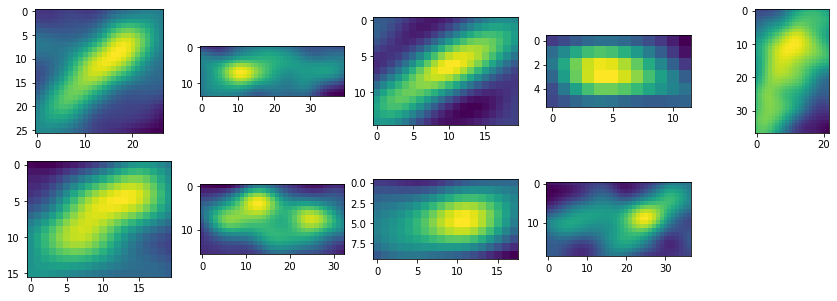

In [19]:
plt.figure(figsize=(15, 5))
for i, island in enumerate([40, 88, 92, 96, 97, 119, 125, 169, 171]):
    plt.subplot(2, 5, i + 1)
    island = img_mP_I.islands[island]
    plt.imshow(island.image)

These all look legitimate, so we'll want to re-run with different flagging options. It'd be good to know why these were flagged.

NOTE -- With the mouse pointer in plot window:
  Press "i" ........ : Get integrated flux densities and mean rms
                       values for the visible portion of the image
  Press "m" ........ : Change min and max scaling values
  Press "n" ........ : Show / hide island IDs
  Press "0" ........ : Reset scaling to default
  Click Gaussian ... : Print Gaussian and source IDs (zoom_rect mode, 
                       toggled with the "zoom" button and indicated in 
                       the lower right corner, must be off)
________________________________________________________________________


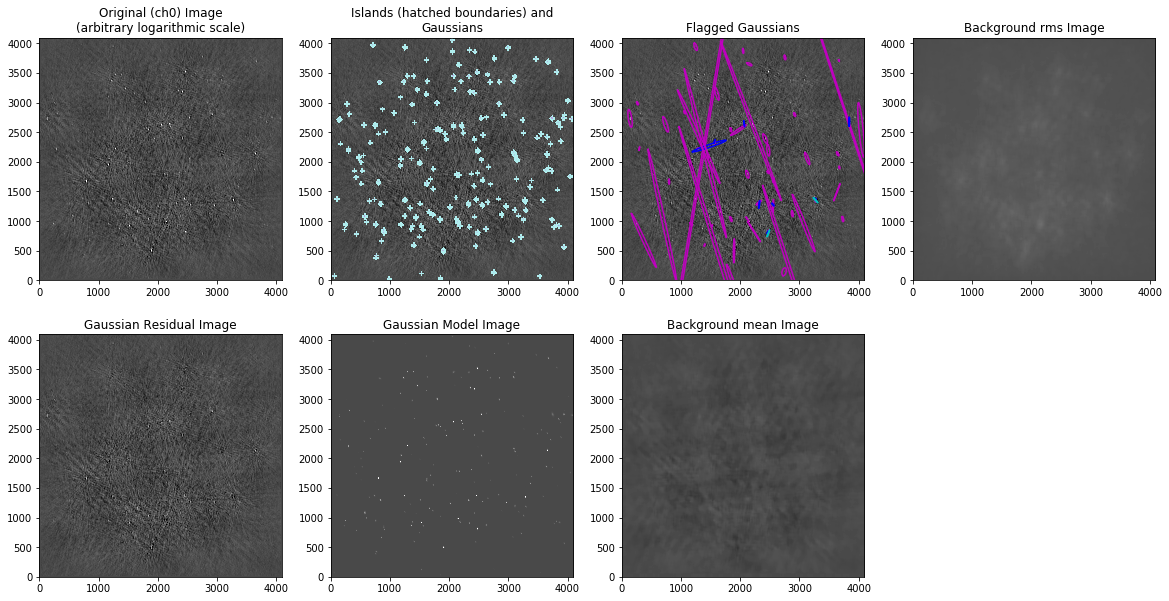

True

In [20]:
img_mP_I.show_fit(ch0_flagged=True)

It's unclear what the different colours mean (presumably the flag reason, but there's no legend). Nevertheless it's pretty obvious that the bright sources have been poorly fit. Let's try again with the wavelet module.

In [99]:
img_mP_I = bdsf.process_image(
    smoothed_path,
    rms_box=(100, 20),
    thresh='hard',
    thresh_isl=3.0,
    thresh_pix=5.0,
    atrous_do=True,
    incl_empty=True)

--> Opened '/home/alger/possum/alger/hamburg/I_04.smoothed.mean.fits'
Image size .............................. : (4096, 4096) pixels
Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (5.91619e-03, 4.38077e-03, -0.7) degrees
Frequency of image ...................... : 743.991 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : 25.134 Jy
--> Calculating background rms and mean images
Using user-specified rms_box ............ : (100, 20) pixels
--> Variation in rms image significant
--> Using 2D map for background rms
--> Variation in mean image significant
--> Using 2D map for background mean
Min/max values of background rms map .... : (8.50e-04, 2.16e-02) Jy/beam
Min/max values of background mean map ... : (-1.20e-02, 8.92e-03) Jy/beam
Minimum number of pixels per island ..... : 20
Number of islands found ................. : 189


Fitting islands with Gaussians .......... : [|----------------------------------------------------------------------------------------------------------------------------] 0/189/Fitting islands with Gaussians .......... : [/----------------------------------------------------------------------------------------------------------------------------] 1/189--Fitting islands with Gaussians .......... : [=----------------------------------------------------------------------------------------------------------------------------] 2/189Fitting islands with Gaussians .......... : [=----------------------------------------------------------------------------------------------------------------------------] 2/189||Fitting islands with Gaussians .......... : [==|--------------------------------------------------------------------------------------------------------------------------] 4/189Fitting islands with Gaussians .......... : [==|--------------------------------------------------------------

\Fitting islands with Gaussians .......... : [==========================\--------------------------------------------------------------------------------------------------] 40/189||Fitting islands with Gaussians .......... : [===========================|-------------------------------------------------------------------------------------------------] 41/189Fitting islands with Gaussians .......... : [===========================|-------------------------------------------------------------------------------------------------] 41/189--Fitting islands with Gaussians .......... : [============================-------------------------------------------------------------------------------------------------] 43/189Fitting islands with Gaussians .......... : [============================-------------------------------------------------------------------------------------------------] 43/189|Fitting islands with Gaussians .......... : [=============================|-----------------------------

\Fitting islands with Gaussians .......... : [====================================================\------------------------------------------------------------------------] 79/189|Fitting islands with Gaussians .......... : [====================================================|------------------------------------------------------------------------] 80/189/Fitting islands with Gaussians .......... : [=====================================================/-----------------------------------------------------------------------] 81/189-Fitting islands with Gaussians .......... : [======================================================-----------------------------------------------------------------------] 82/189\Fitting islands with Gaussians .......... : [======================================================\----------------------------------------------------------------------] 83/189\Fitting islands with Gaussians .......... : [======================================================\----

\Fitting islands with Gaussians .......... : [==============================================================================\----------------------------------------------] 119/189|Fitting islands with Gaussians .......... : [===============================================================================|---------------------------------------------] 120/189/Fitting islands with Gaussians .......... : [================================================================================/--------------------------------------------] 121/189/Fitting islands with Gaussians .......... : [================================================================================/--------------------------------------------] 121/189\Fitting islands with Gaussians .......... : [=================================================================================\-------------------------------------------] 123/189|Fitting islands with Gaussians .......... : [======================================================

Fitting islands with Gaussians .......... : [========================================================================================================---------------------] 158/189\Fitting islands with Gaussians .......... : [=========================================================================================================\-------------------] 159/189|Fitting islands with Gaussians .......... : [=========================================================================================================|-------------------] 160/189/Fitting islands with Gaussians .......... : [==========================================================================================================/------------------] 161/189-Fitting islands with Gaussians .......... : [===========================================================================================================------------------] 162/189\Fitting islands with Gaussians .......... : [=======================================================

Total number of Gaussians fit to image .. : 212
Total flux density in model ............. : 62.476 Jy

--> Wavelet scale #1
--> Calculating background rms and mean images
Using user-specified rms_box ............ : (100, 33) pixels
--> Variation in rms image significant
--> Using 2D map for background rms
--> Variation in mean image not significant
--> Using constant background mean
Min/max values of background rms map .... : (6.10e-04, 1.98e-02) Jy/beam
Value of background mean ................ : -5e-05 Jy/beam
Number of islands found ................. : 51


Fitting islands with Gaussians .......... : [|--------------------------------------------------] 0/51/Fitting islands with Gaussians .......... : [=/-------------------------------------------------] 1/51-Fitting islands with Gaussians .......... : [==-------------------------------------------------] 2/51\Fitting islands with Gaussians .......... : [===\-----------------------------------------------] 3/51||Fitting islands with Gaussians .......... : [====|----------------------------------------------] 4/51Fitting islands with Gaussians .......... : [====|----------------------------------------------] 4/51-Fitting islands with Gaussians .......... : [======---------------------------------------------] 6/51\Fitting islands with Gaussians .......... : [=======\-------------------------------------------] 7/51\Fitting islands with Gaussians .......... : [=======\-------------------------------------------] 7/51/Fitting islands with Gaussians .......... : [=========/------------------

Total number of Gaussians fit to image .. : 20


Checking islands for overlap ............ : [|--------------------------------------------------] 0/51/Checking islands for overlap ............ : [=/-------------------------------------------------] 1/51-Checking islands for overlap ............ : [==-------------------------------------------------] 2/51\Checking islands for overlap ............ : [===\-----------------------------------------------] 3/51|Checking islands for overlap ............ : [====|----------------------------------------------] 4/51/Checking islands for overlap ............ : [=====/---------------------------------------------] 5/51-Checking islands for overlap ............ : [======---------------------------------------------] 6/51\Checking islands for overlap ............ : [=======\-------------------------------------------] 7/51|Checking islands for overlap ............ : [========|------------------------------------------] 8/51/Checking islands for overlap ............ : [=========/------------------

--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 19

--> Wavelet scale #2
--> Calculating background rms and mean images
Using user-specified rms_box ............ : (100, 33) pixels
--> Variation in rms image significant
--> Using 2D map for background rms
--> Variation in mean image not significant
--> Using constant background mean
Min/max values of background rms map .... : (5.43e-04, 1.71e-02) Jy/beam
Value of background mean ................ : -7e-05 Jy/beam
Number of islands found ................. : 30


Fitting islands with Gaussians .......... : [|-----------------------------] 0/30/Fitting islands with Gaussians .......... : [=/----------------------------] 1/30-Fitting islands with Gaussians .......... : [==----------------------------] 2/30-Fitting islands with Gaussians .......... : [==----------------------------] 2/30\\Fitting islands with Gaussians .......... : [===\--------------------------] 3/30Fitting islands with Gaussians .......... : [===\--------------------------] 3/30|Fitting islands with Gaussians .......... : [====|-------------------------] 4/30-Fitting islands with Gaussians .......... : [======------------------------] 6/30\Fitting islands with Gaussians .......... : [=======\----------------------] 7/30|Fitting islands with Gaussians .......... : [========|---------------------] 8/30/Fitting islands with Gaussians .......... : [=========/--------------------] 9/30-Fitting islands with Gaussians .......... : [==========--------------------] 10/30\Fitting islands

Total number of Gaussians fit to image .. : 8



Checking islands for overlap ............ : [|-----------------------------] 0/30/Checking islands for overlap ............ : [=/----------------------------] 1/30-Checking islands for overlap ............ : [==----------------------------] 2/30\Checking islands for overlap ............ : [===\--------------------------] 3/30|Checking islands for overlap ............ : [====|-------------------------] 4/30/Checking islands for overlap ............ : [=====/------------------------] 5/30-Checking islands for overlap ............ : [======------------------------] 6/30\Checking islands for overlap ............ : [=======\----------------------] 7/30|Checking islands for overlap ............ : [========|---------------------] 8/30/Checking islands for overlap ............ : [=========/--------------------] 9/30-Checking islands for overlap ............ : [==========--------------------] 10/30\Checking islands for overlap ............ : [===========\------------------] 11/30|Checking isla

--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 8



--> Wavelet scale #3
--> Calculating background rms and mean images
Using user-specified rms_box ............ : (100, 33) pixels
--> Variation in rms image significant
--> Using 2D map for background rms
--> Variation in mean image not significant
--> Using constant background mean
Min/max values of background rms map .... : (4.80e-04, 1.34e-02) Jy/beam
Value of background mean ................ : -0.0001 Jy/beam
Number of islands found ................. : 13


Fitting islands with Gaussians .......... : [|------------] 0/13//Fitting islands with Gaussians .......... : [=/-----------] 1/13Fitting islands with Gaussians .......... : [=/-----------] 1/13\\Fitting islands with Gaussians .......... : [===\---------] 3/13Fitting islands with Gaussians .......... : [===\---------] 3/13|Fitting islands with Gaussians .......... : [====|--------] 4/13/Fitting islands with Gaussians .......... : [=====/-------] 5/13--Fitting islands with Gaussians .......... : [======-------] 6/13Fitting islands with Gaussians .......... : [======-------] 6/13/Fitting islands with Gaussians .......... : [=========/---] 9/13-Fitting islands with Gaussians .......... : [==========---] 10/13\Fitting islands with Gaussians .......... : [===========\-] 11/13|Fitting islands with Gaussians .......... : [============|] 12/13Fitting islands with Gaussians .......... : [=============] 13/13Fitting islands with Gaussians .......... : [=============] 13/13

Total number of Gaussians fit to image .. : 7



Checking islands for overlap ............ : [|------------] 0/13/Checking islands for overlap ............ : [=/-----------] 1/13-Checking islands for overlap ............ : [==-----------] 2/13\Checking islands for overlap ............ : [===\---------] 3/13|Checking islands for overlap ............ : [====|--------] 4/13/Checking islands for overlap ............ : [=====/-------] 5/13-Checking islands for overlap ............ : [======-------] 6/13\Checking islands for overlap ............ : [=======\-----] 7/13|Checking islands for overlap ............ : [========|----] 8/13/Checking islands for overlap ............ : [=========/---] 9/13-Checking islands for overlap ............ : [==========---] 10/13\Checking islands for overlap ............ : [===========\-] 11/13|Checking islands for overlap ............ : [============|] 12/13Checking islands for overlap ............ : [=============] 13/13Checking islands for overlap ............ : [=============] 13/13

--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 7



--> Wavelet scale #4

--> Aborted


NOTE -- With the mouse pointer in plot window:
  Press "i" ........ : Get integrated flux densities and mean rms
                       values for the visible portion of the image
  Press "m" ........ : Change min and max scaling values
  Press "n" ........ : Show / hide island IDs
  Press "0" ........ : Reset scaling to default
  Click Gaussian ... : Print Gaussian and source IDs (zoom_rect mode, 
                       toggled with the "zoom" button and indicated in 
                       the lower right corner, must be off)
________________________________________________________________________


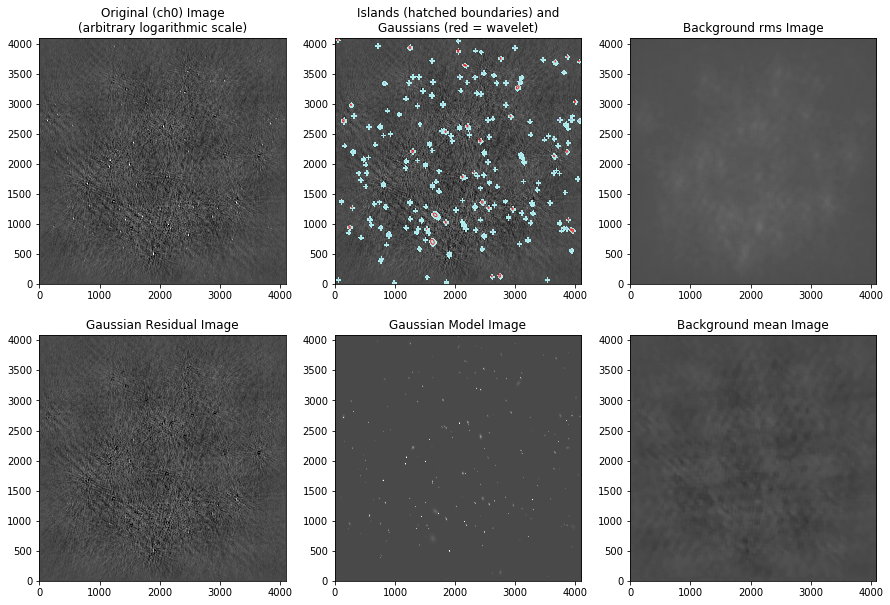

True

In [22]:
img_mP.show_fit()

We'll just assume that works for now. We can write the catalogue to a file:

In [10]:
img_mP_I = bdsf.process_image(
    smoothed_path,
    rms_box=(100, 20),
    thresh='hard',
    thresh_isl=3.0,
    thresh_pix=5.0,
    group_by_isl=True)

--> Opened '/home/alger/possum/alger/hamburg/I_04.smoothed.mean.fits'
Image size .............................. : (4096, 4096) pixels
Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (5.91619e-03, 4.38077e-03, -0.7) degrees
Frequency of image ...................... : 743.991 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : 25.134 Jy
--> Calculating background rms and mean images
Using user-specified rms_box ............ : (100, 20) pixels
--> Variation in rms image significant
--> Using 2D map for background rms
--> Variation in mean image significant
--> Using 2D map for background mean
Min/max values of background rms map .... : (8.50e-04, 2.16e-02) Jy/beam
Min/max values of background mean map ... : (-1.20e-02, 8.92e-03) Jy/beam
Minimum number of pixels per island ..... : 20
Number of islands found ................. : 189


Fitting islands with Gaussians .......... : [|-------------------------] 0/189//Fitting islands with Gaussians .......... : [/-------------------------] 1/189Fitting islands with Gaussians .......... : [/-------------------------] 1/189\Fitting islands with Gaussians .......... : [\-------------------------] 3/189|Fitting islands with Gaussians .......... : [|-------------------------] 4/189/Fitting islands with Gaussians .......... : [/-------------------------] 5/189--Fitting islands with Gaussians .......... : [--------------------------] 6/189Fitting islands with Gaussians .......... : [--------------------------] 6/189\Fitting islands with Gaussians .......... : [\-------------------------] 7/189|Fitting islands with Gaussians .......... : [=|------------------------] 8/189--Fitting islands with Gaussians .......... : [=-------------------------] 10/189Fitting islands with Gaussians .......... : [=-------------------------] 10/189|Fitting islands with Gaussians .......... : [=|---

|Fitting islands with Gaussians .......... : [==========|---------------] 76/189//Fitting islands with Gaussians .......... : [==========/---------------] 77/189Fitting islands with Gaussians .......... : [==========/---------------] 77/189\Fitting islands with Gaussians .......... : [==========\---------------] 78/189|Fitting islands with Gaussians .......... : [==========|---------------] 79/189/Fitting islands with Gaussians .......... : [===========/--------------] 80/189-Fitting islands with Gaussians .......... : [===========---------------] 81/189\\Fitting islands with Gaussians .......... : [===========\--------------] 82/189Fitting islands with Gaussians .......... : [===========\--------------] 82/189/Fitting islands with Gaussians .......... : [===========/--------------] 84/189/Fitting islands with Gaussians .......... : [===========/--------------] 84/189\Fitting islands with Gaussians .......... : [===========\--------------] 86/189|Fitting islands with Gaussians ........

\Fitting islands with Gaussians .......... : [====================\-----] 150/189|Fitting islands with Gaussians .......... : [====================|-----] 151/189//Fitting islands with Gaussians .......... : [====================/-----] 152/189Fitting islands with Gaussians .......... : [====================/-----] 152/189\Fitting islands with Gaussians .......... : [=====================\----] 154/189\Fitting islands with Gaussians .......... : [=====================\----] 154/189/Fitting islands with Gaussians .......... : [=====================/----] 156/189-Fitting islands with Gaussians .......... : [=====================-----] 157/189\Fitting islands with Gaussians .......... : [=====================\----] 158/189|Fitting islands with Gaussians .......... : [=====================|----] 159/189/Fitting islands with Gaussians .......... : [======================/---] 160/189-Fitting islands with Gaussians .......... : [======================----] 161/189\Fitting islands with Gaussi

Total number of Gaussians fit to image .. : 212
Total flux density in model ............. : 62.476 Jy
--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 180
    Island #40 (x=1173, y=952)
    Island #88 (x=2050, y=3868)
    Island #92 (x=2111, y=1046)
    Island #96 (x=2142, y=1005)
    Island #97 (x=2150, y=3649)
    Island #119 (x=2468, y=1824)
    Island #125 (x=2558, y=1693)
    Island #169 (x=3675, y=1903)
    Island #171 (x=3732, y=1034)
Please check these islands. If they are valid islands and
should be fit, try adjusting the flagging options (use
show_fit with "ch0_flagged=True" to see the flagged Gaussians)
or enabling the wavelet module (with "atrous_do=True").
To include empty islands in output source catalogs, set
incl_empty=True in the write_catalog task.


In [11]:
len(img_mP_I.islands)

189

In [12]:
bdsf_cat_path = '/home/alger/possum/alger/hamburg/I_04.smoothed.mean.bdsf_gaul.csv'
img_mP_I.write_catalog(outfile=bdsf_cat_path, format='csv', catalog_type='gaul', clobber=True, incl_empty=True)

bdsf_cat_path_isle = '/home/alger/possum/alger/hamburg/I_04.smoothed.mean.bdsf_isle.csv'
img_mP_I.write_catalog(outfile=bdsf_cat_path_isle, format='csv', catalog_type='srl', clobber=True, incl_empty=True)

--> Wrote ASCII file '/home/alger/possum/alger/hamburg/I_04.smoothed.mean.bdsf_gaul.csv'
--> Wrote ASCII file '/home/alger/possum/alger/hamburg/I_04.smoothed.mean.bdsf_isle.csv'


True

Then we can read it back in.

In [13]:
bdsf_cat_isle = pandas.read_csv(bdsf_cat_path_isle, skiprows=5)
bdsf_cat_gaul = pandas.read_csv(bdsf_cat_path, skiprows=5)
len(bdsf_cat_gaul), len(bdsf_cat_isle)

(212, 189)

In [14]:
# bdsf_cat_isle.set_index([' Isl_id', '# Source_id'])

We do lose some information though, since we no longer have the island shapes. I think these are stored in the BBS format, but this is beyond me right now. Let's instead go through the islands we found in Python. These all have bounding boxes etc, which makes cutouts really easy.

In [15]:
bdsf_polarised_cutouts = []
# bdsf_Q_cutouts = []
# bdsf_U_cutouts = []
# bdsf_P_cutouts = []
for island in tqdm(img_mP_I.islands):
    bbox = (slice(None, None), 0) + tuple(island.bbox[::-1])
    cutout_Q = Q[0].data[bbox]
    cutout_U = U[0].data[bbox]
    bdsf_polarised_cutouts.append(numpy.transpose(cutout_Q + 1j * cutout_U, (0, 2, 1)))
#     bdsf_Q_cutouts.append(cutout_Q)
#     bdsf_U_cutouts.append(cutout_U)
#     assert cutout_U.shape[0] == 288
#     bdsf_P_cutouts.append(numpy.hypot(cutout_Q, cutout_U))

In [16]:
bdsf_intensity_cutouts = []
for island in tqdm(img_mP_I.islands):
    bbox = (slice(None, None), 0) + tuple(island.bbox[::-1])
    cutout_I = I[0].data[bbox]
    bdsf_intensity_cutouts.append(numpy.transpose(cutout_I, (0, 2, 1)))

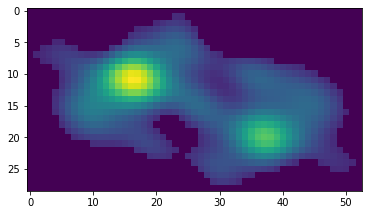

In [17]:
plt.imshow(img_mP_I.islands[2].image * ~img_mP_I.islands[2].mask_active)

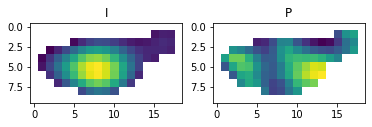

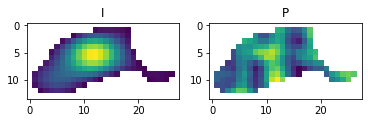

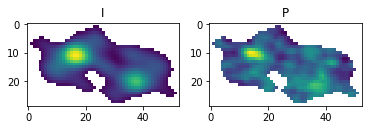

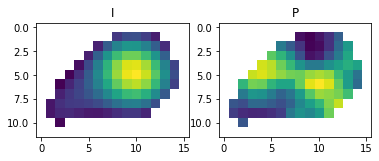

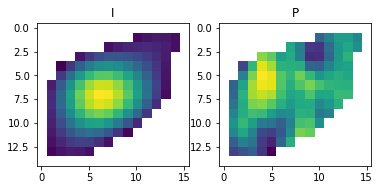

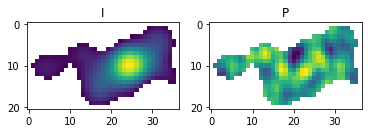

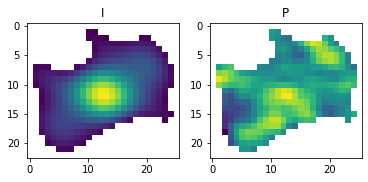

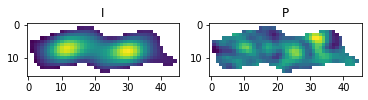

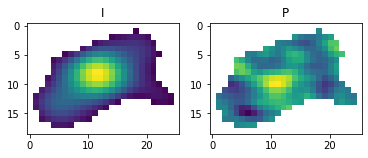

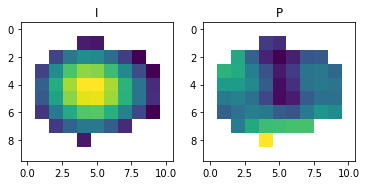

In [18]:
for cutout_i, cutout_p in zip(img_mP_I.islands[:10], bdsf_polarised_cutouts):
    plt.subplot(1, 2, 1)
    plt.imshow(numpy.where(
         ~cutout_i.mask_active,
        cutout_i.image,
        numpy.nan))
    plt.title('I')
    plt.subplot(1, 2, 2)
    plt.imshow(numpy.where(
         ~cutout_i.mask_active,
        abs(cutout_p).mean(axis=0),
        numpy.nan))
    plt.title('P')
    plt.show()

In [19]:
significant = []
sign_levels = numpy.linspace(7, 10, 10)
for sign in sign_levels:
    significant.append([(sign * 1e-3 < c).any() for c in (aegean_polarised_cutouts)])

NameError: name 'aegean_polarised_cutouts' is not defined

In [85]:
plt.plot(sign_levels, numpy.sum(significant, axis=1), marker='x')
plt.xlabel('Flux density cutoff (mJy/beam)')
# plt.axvline(0.005562427 * 1e3, linestyle='--', c='grey')

NameError: name 'sign_levels' is not defined

In [20]:
from RMutils import util_RM


phis = numpy.linspace(-100, 100, 200)
freqs = numpy.loadtxt('/home/alger/possum/racs/freqs_04.txt')

In [21]:
rmsynths = []
masks = []
ints = []
pols = []
for i, ii, ehh in zip(tqdm(bdsf_polarised_cutouts), bdsf_intensity_cutouts, img_mP_I.islands):
    pols.append(i)
    ints.append(ii)
    masks.append(ehh.mask_active)
    rmsynths.append(util_RM.do_rmsynth_planes(i.real, i.imag, (3e8 / freqs) ** 2, phis)[0])

In [22]:
gau = img_mP_I.islands[2].gaul[0]
for name in dir(gau):
    try:
        attr = getattr(gau, name)
        print(name, attr.shape)
    except AttributeError:
        continue

gresid_mean ()
gresid_rms ()
mean ()
peak_fluxE ()
rms ()
total_flux ()
total_fluxE ()
total_flux_isl ()
total_flux_islE ()


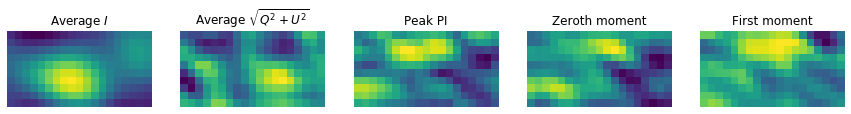

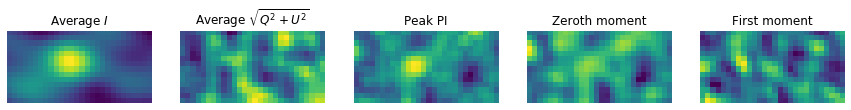

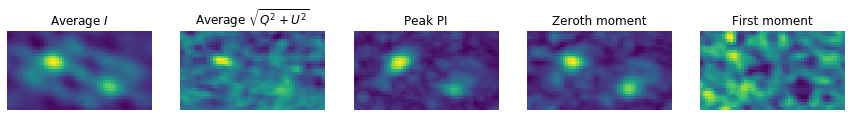

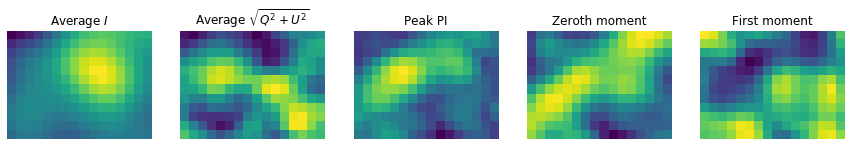

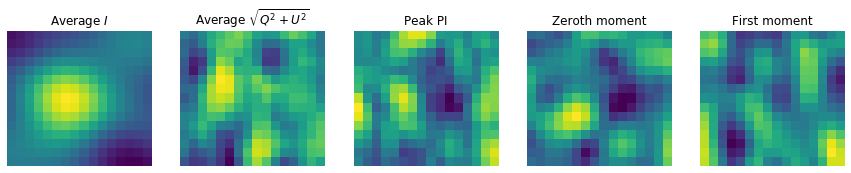

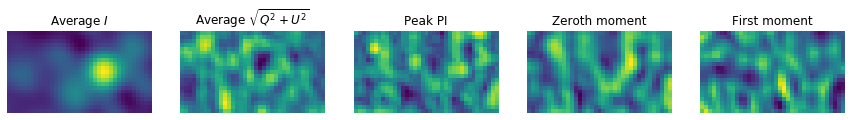

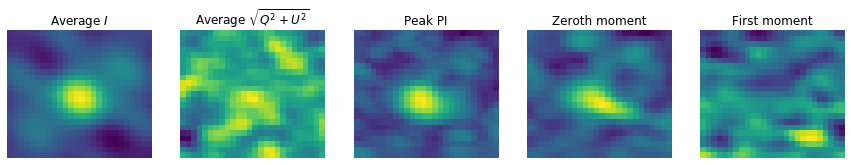

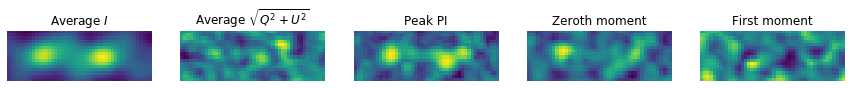

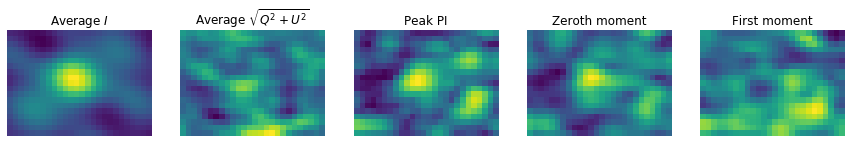

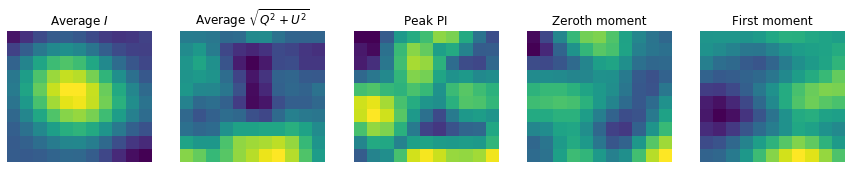

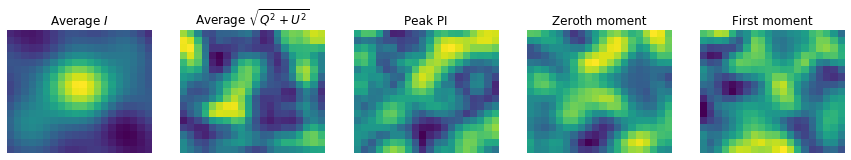

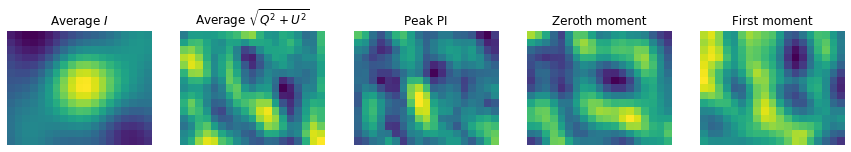

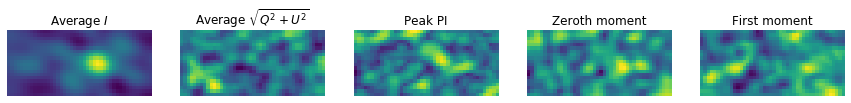

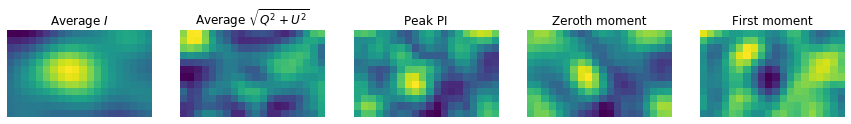

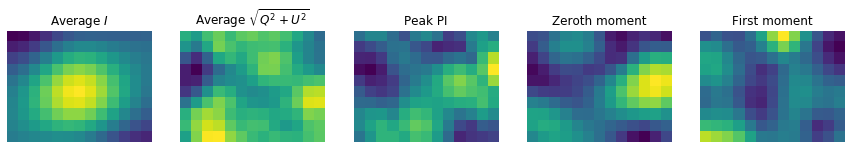

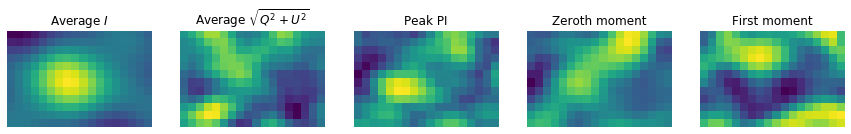

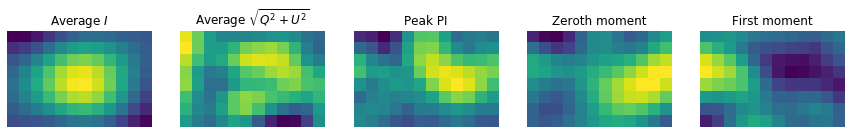

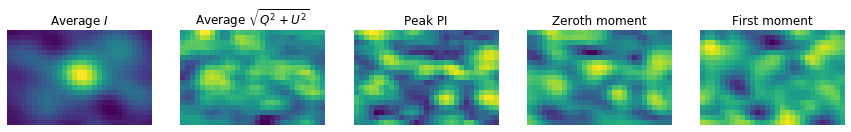

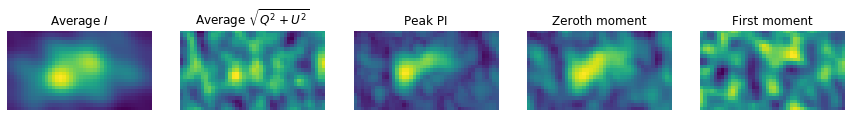

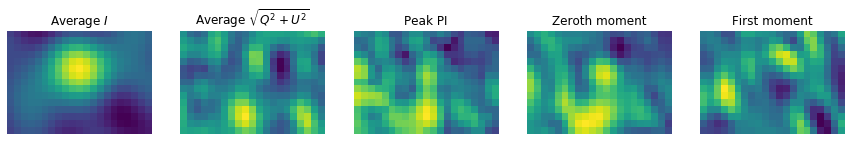

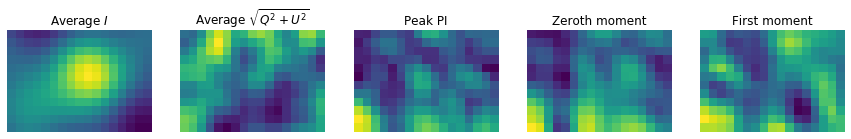

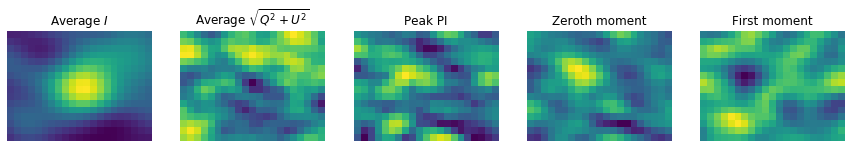

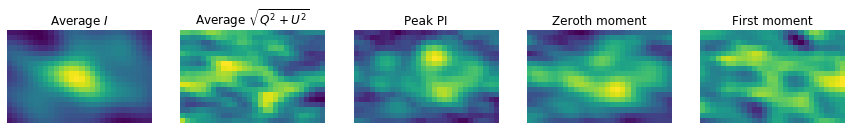

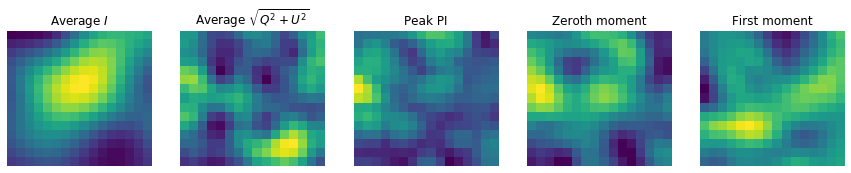

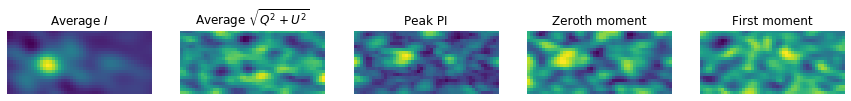

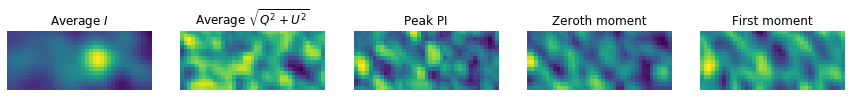

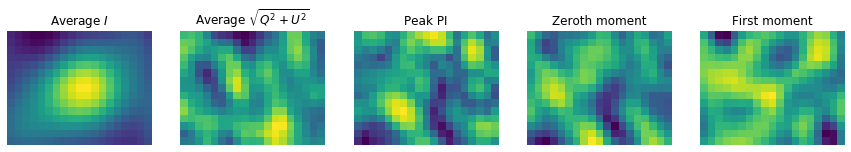

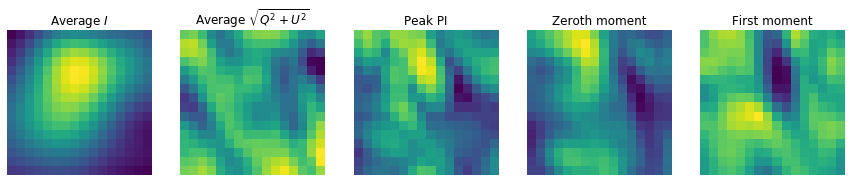

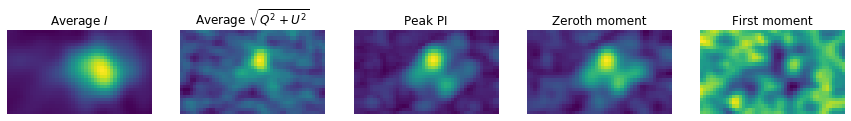

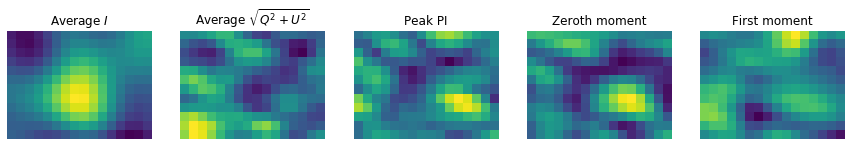

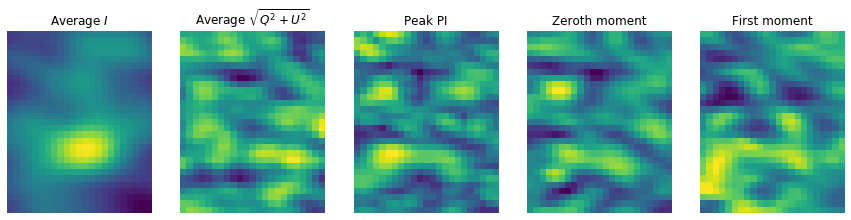

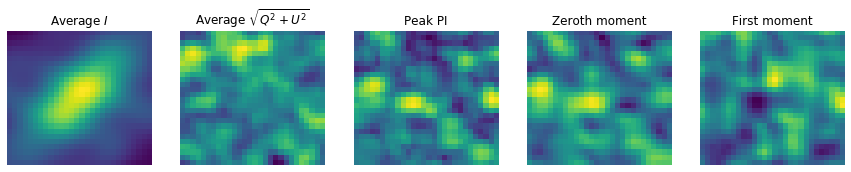

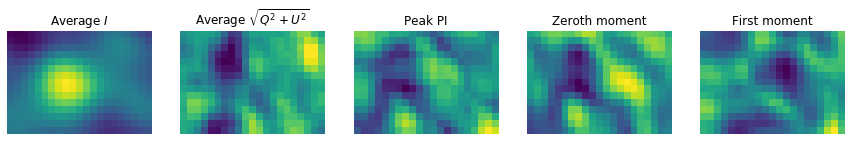

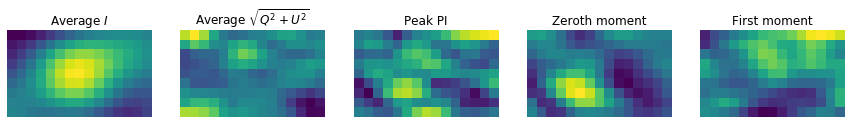

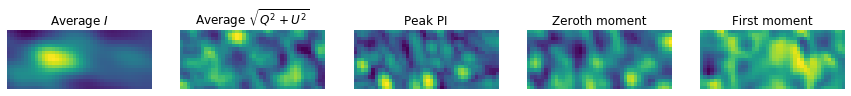

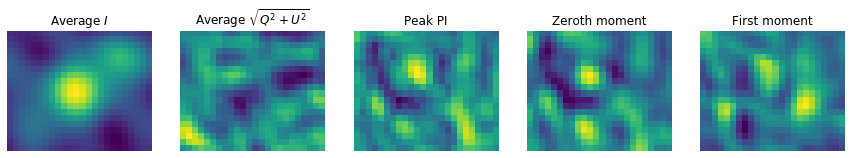

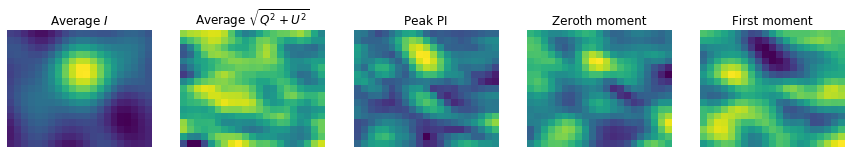

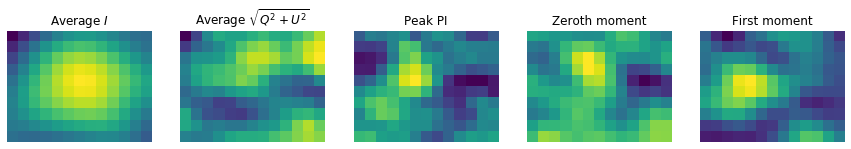

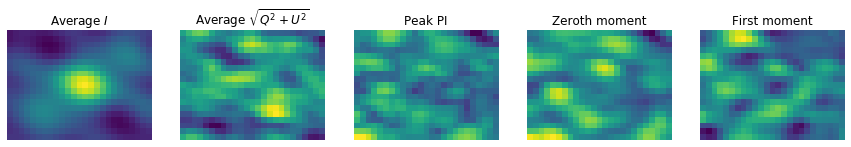

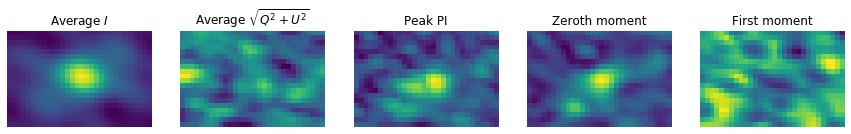

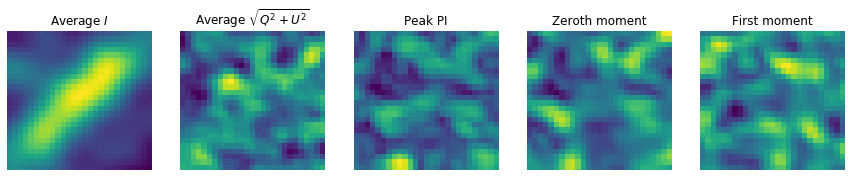

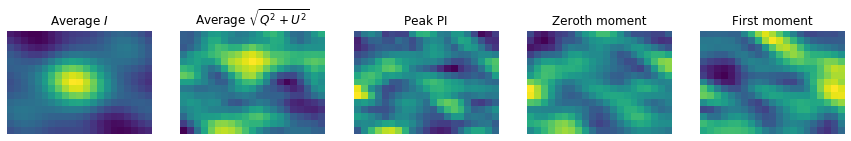

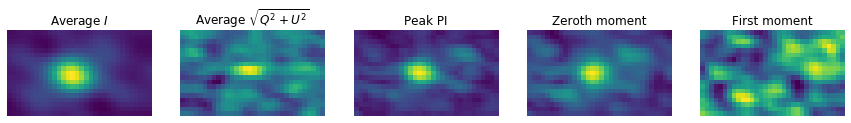

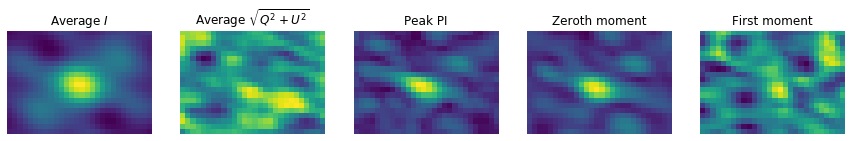

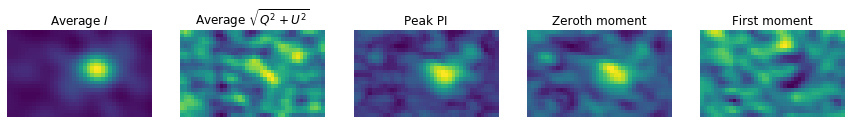

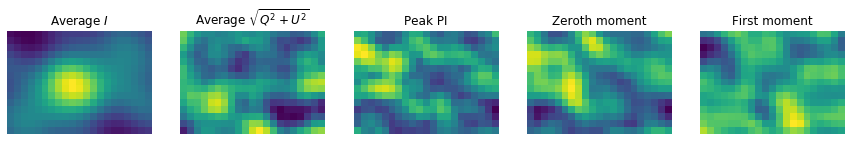

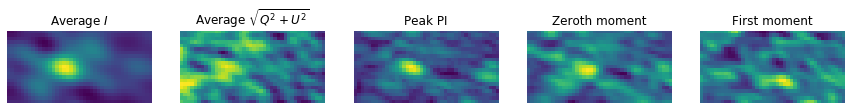

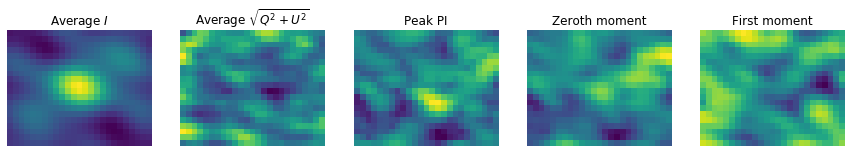

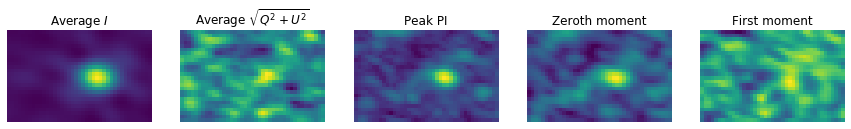

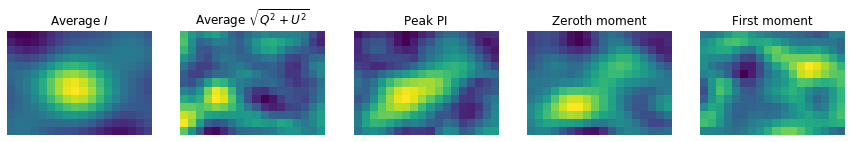

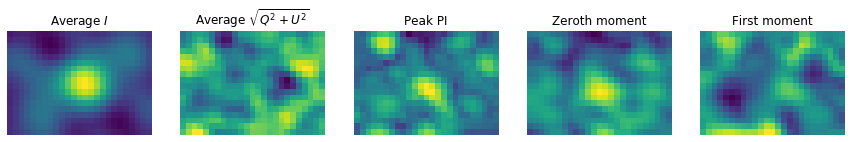

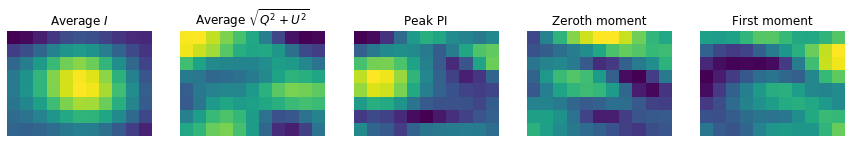

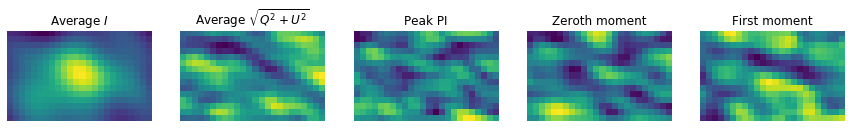

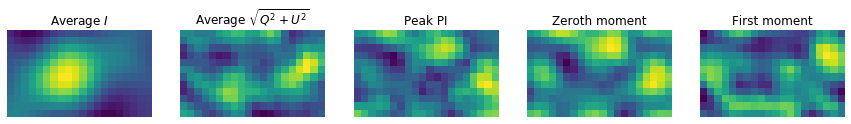

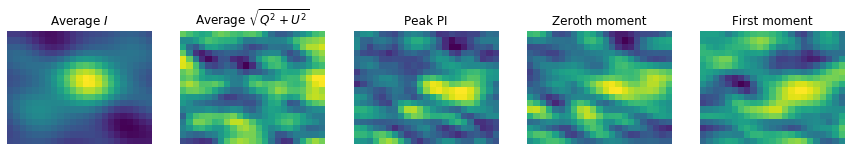

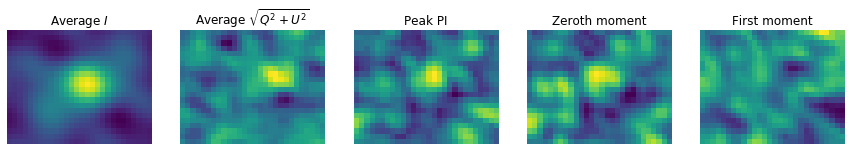

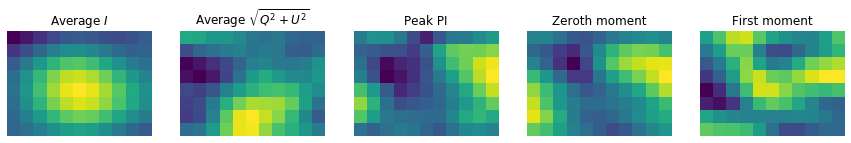

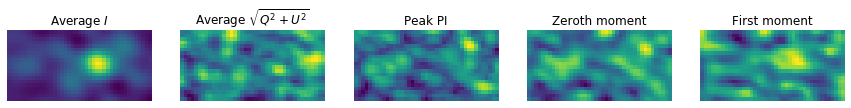

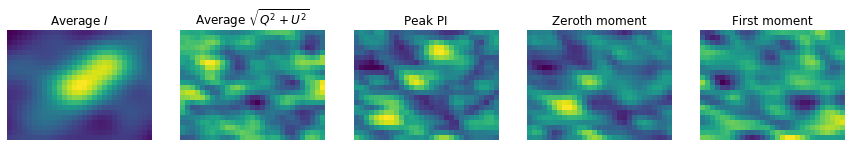

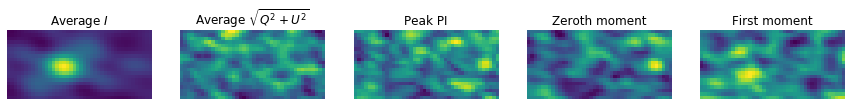

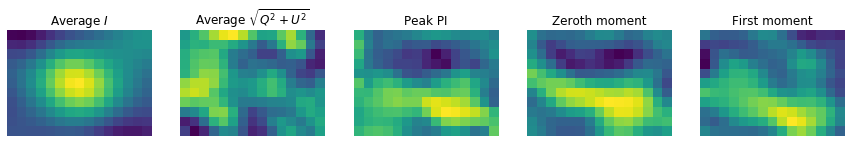

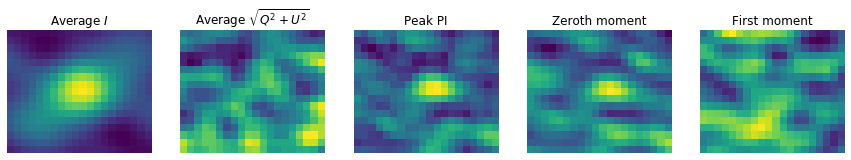

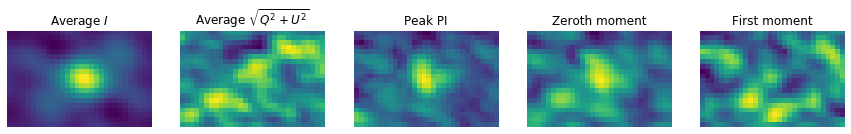

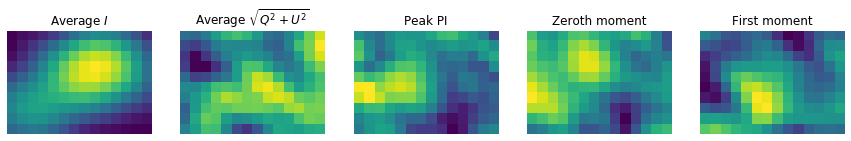

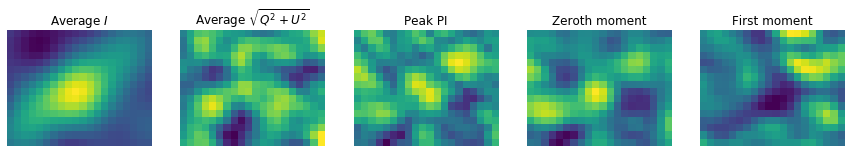

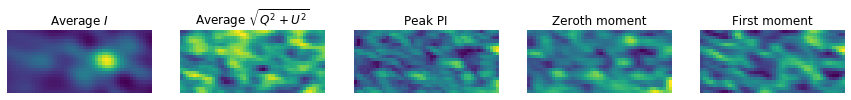

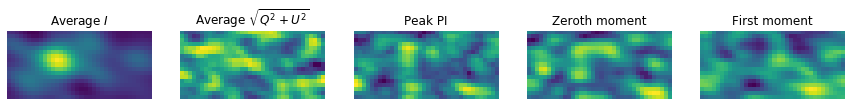

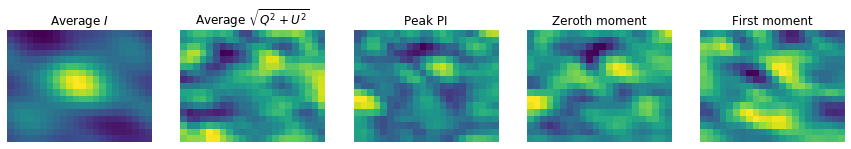

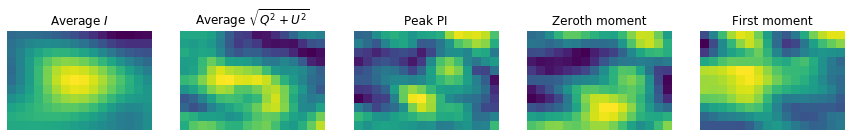

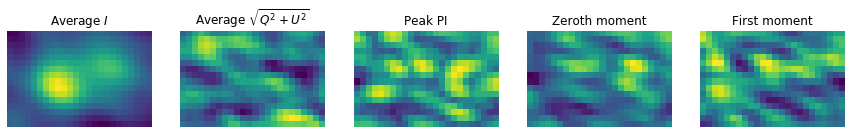

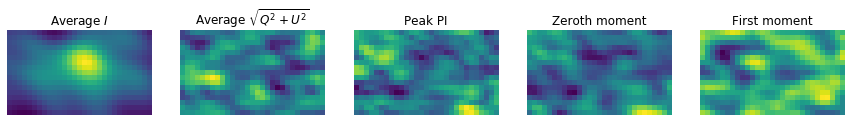

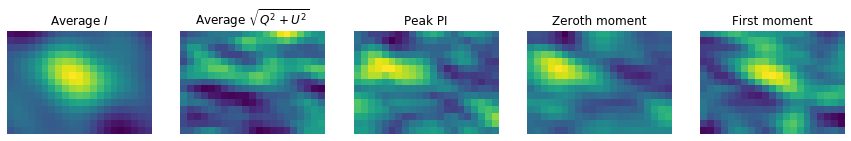

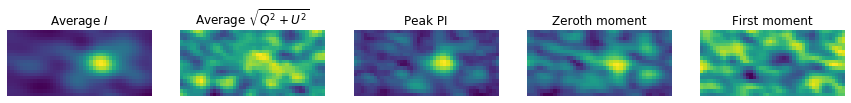

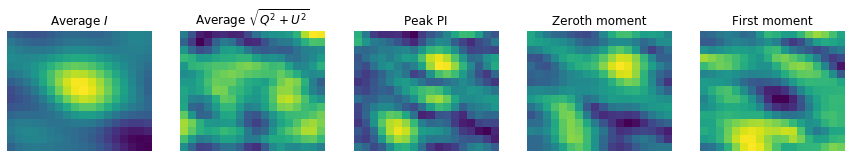

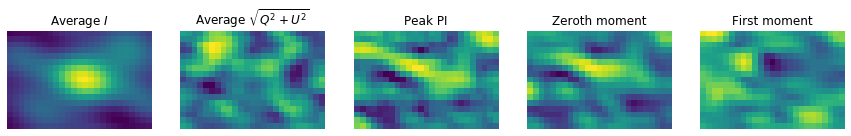

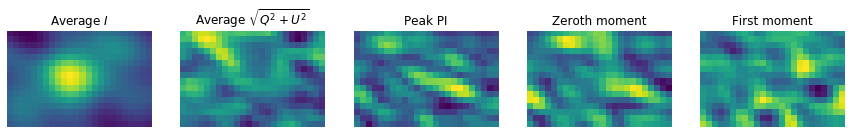

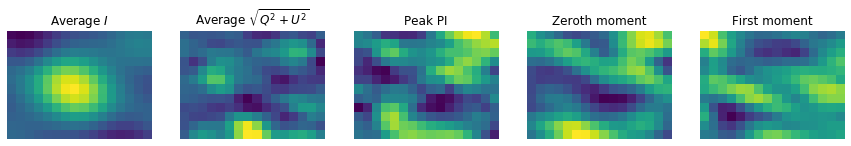

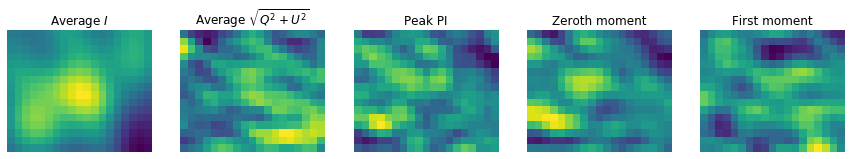

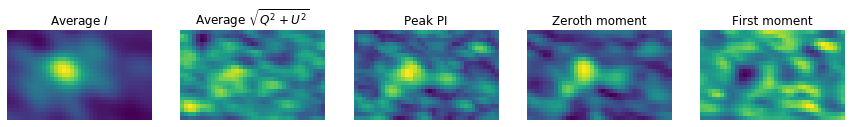

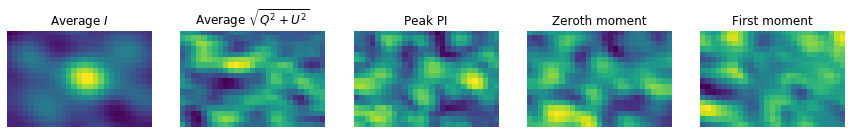

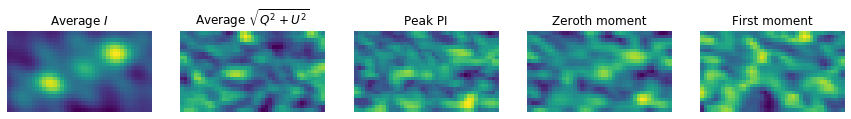

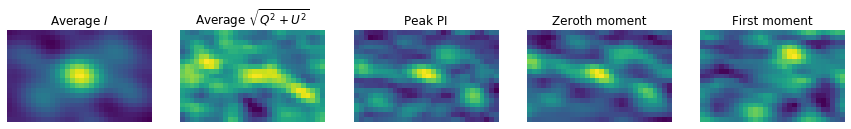

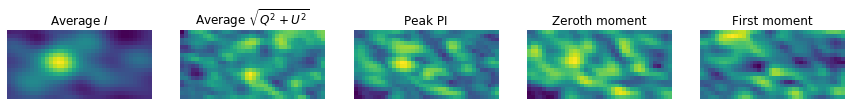

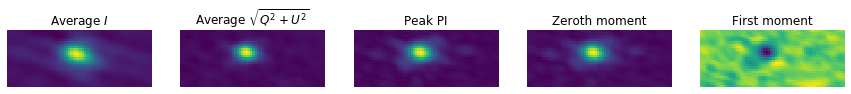

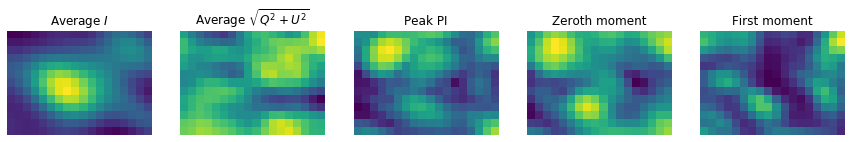

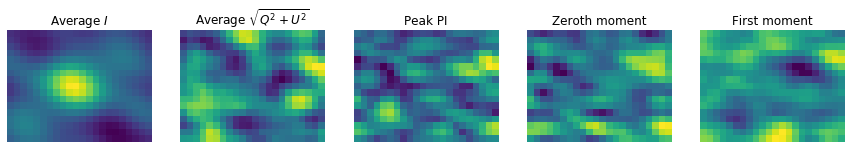

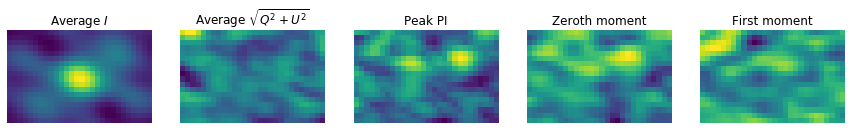

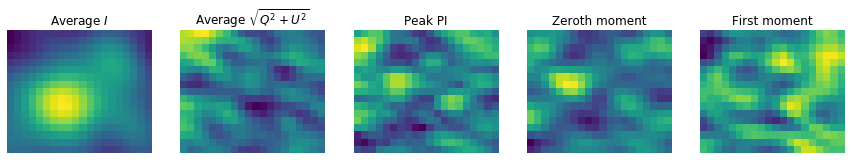

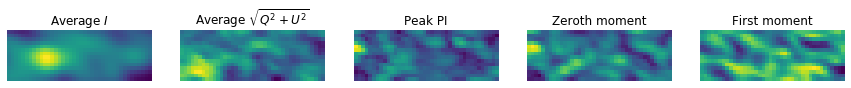

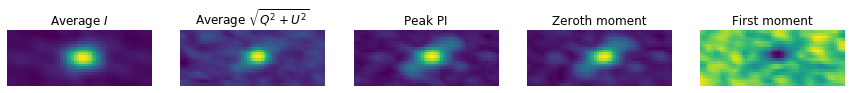

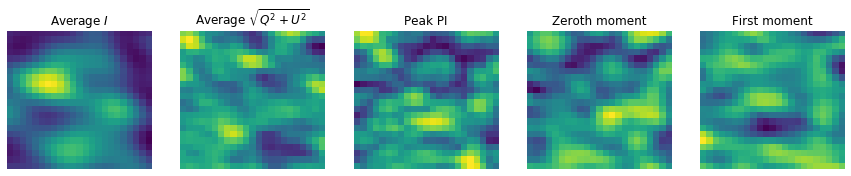

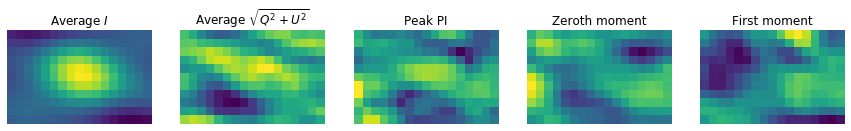

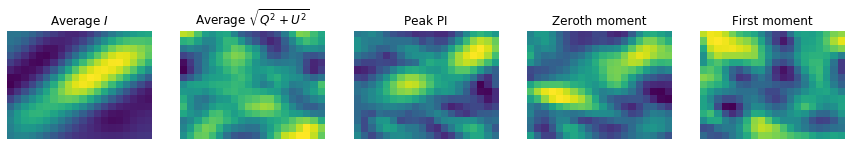

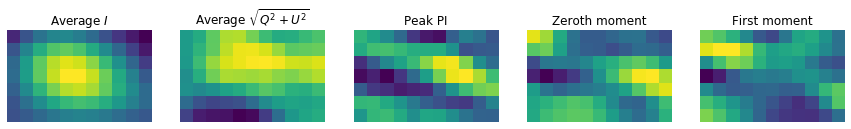

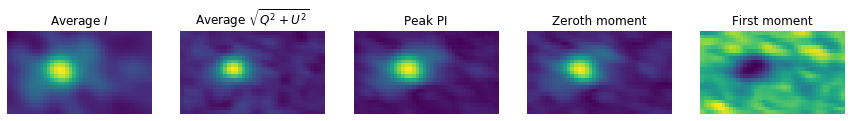

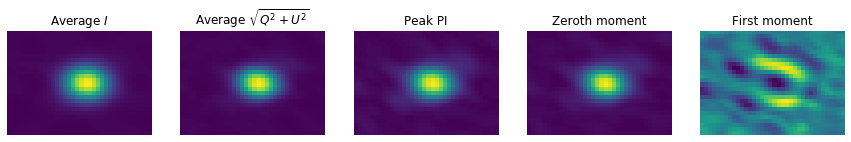

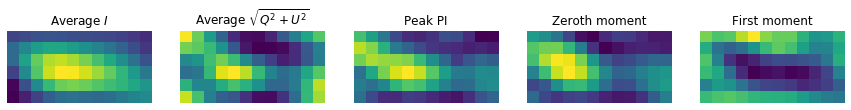

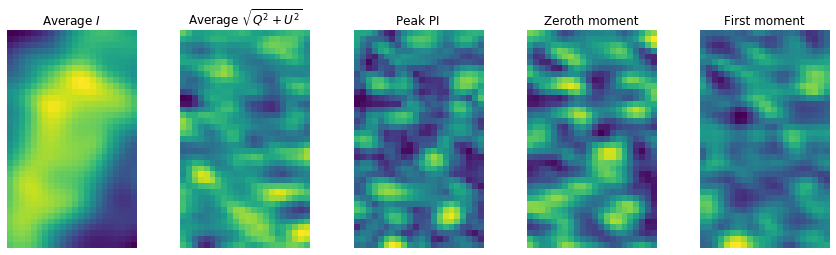

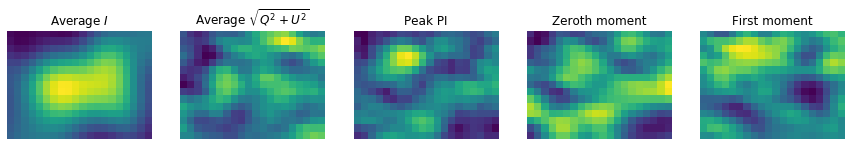

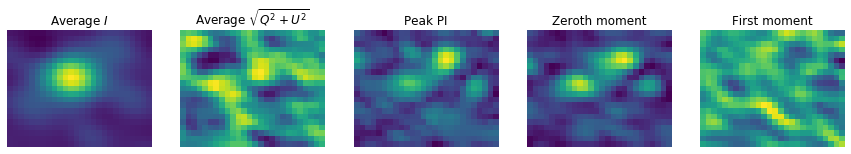

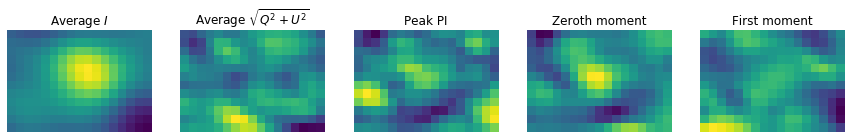

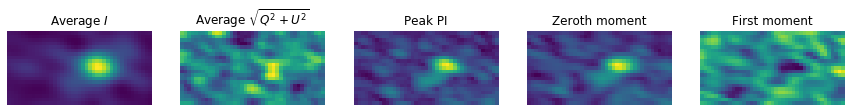

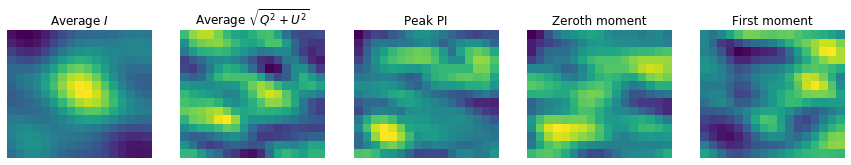

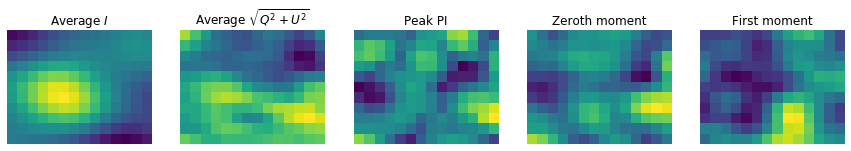

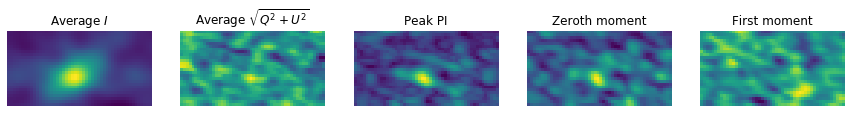

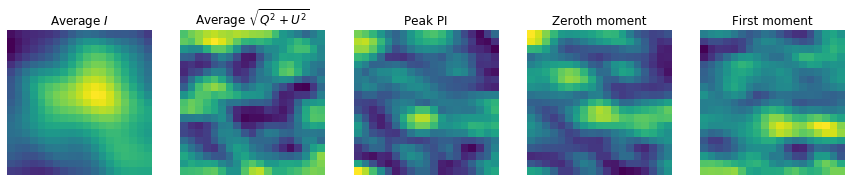

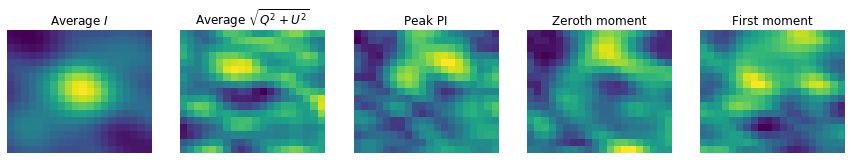

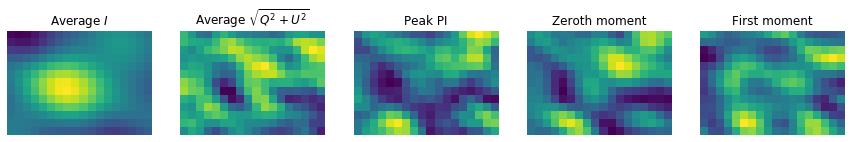

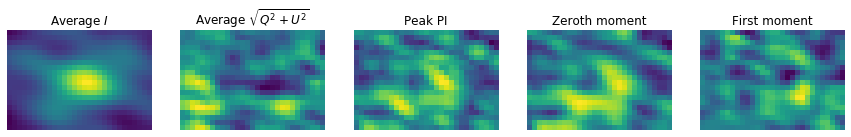

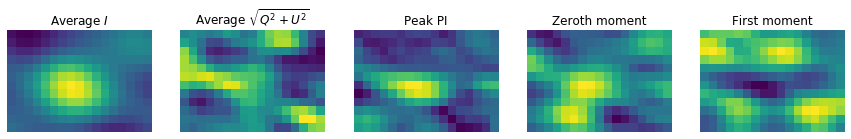

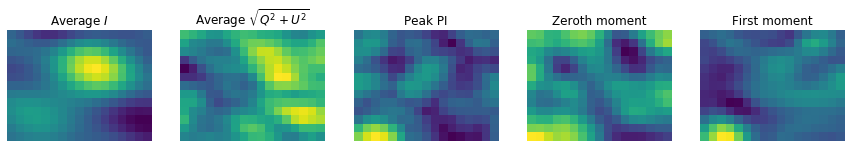

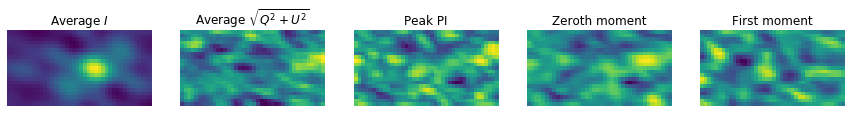

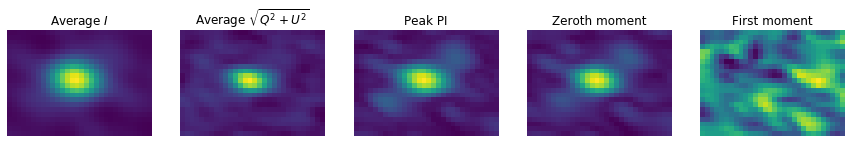

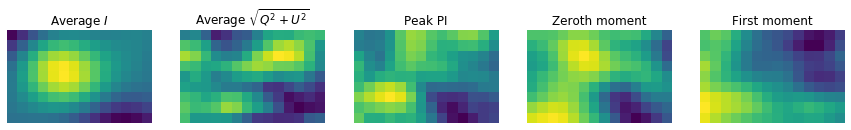

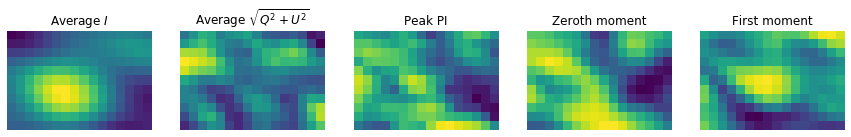

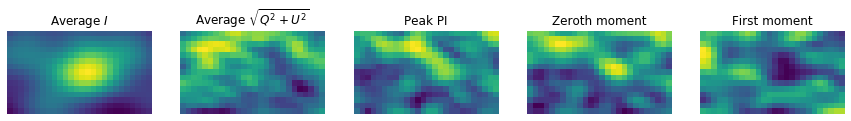

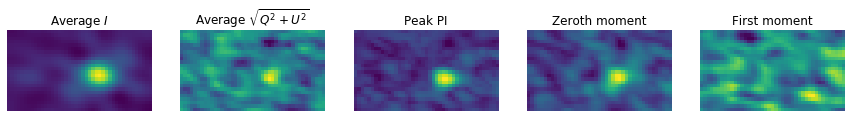

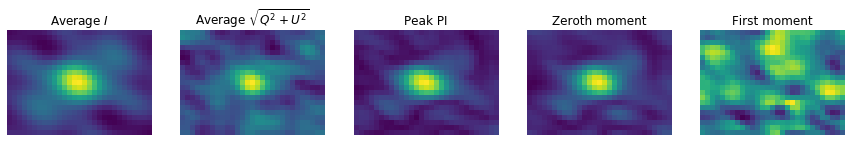

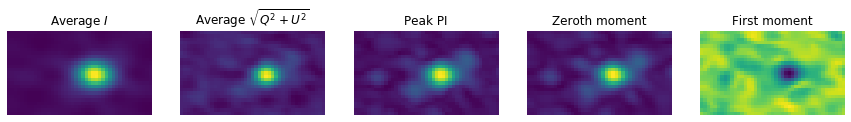

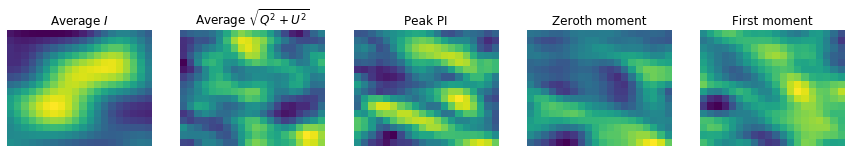

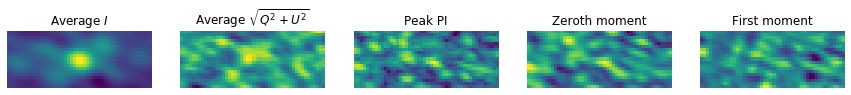

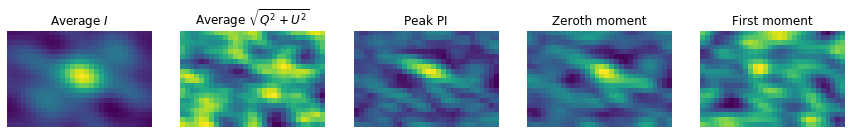

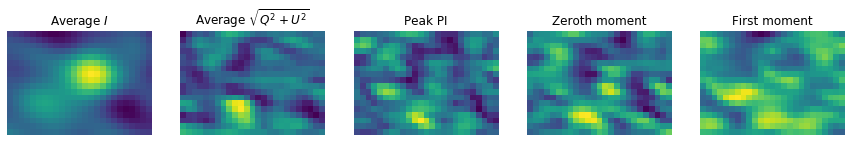

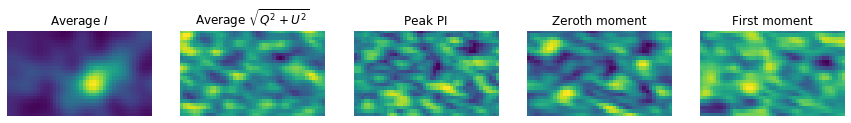

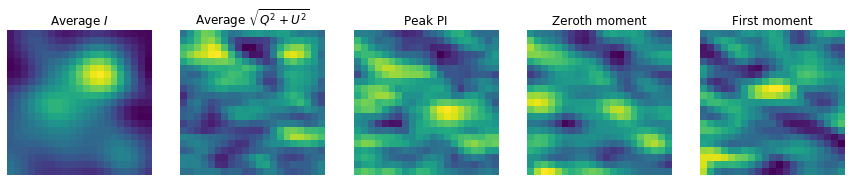

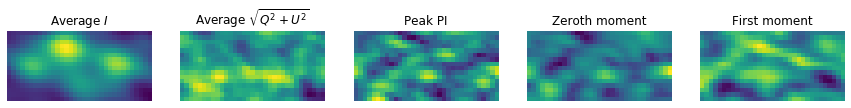

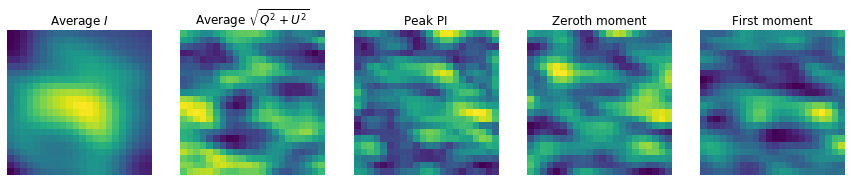

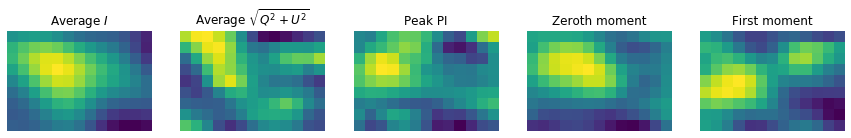

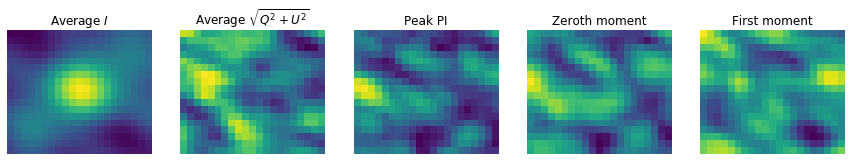

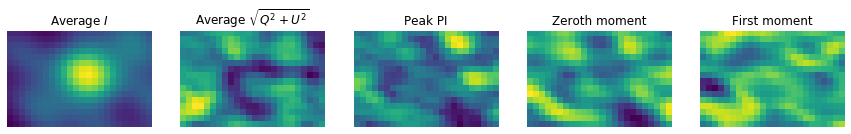

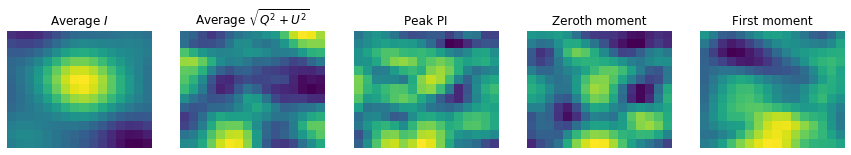

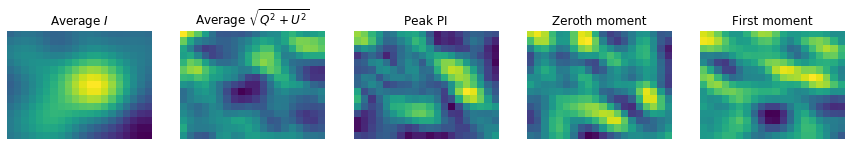

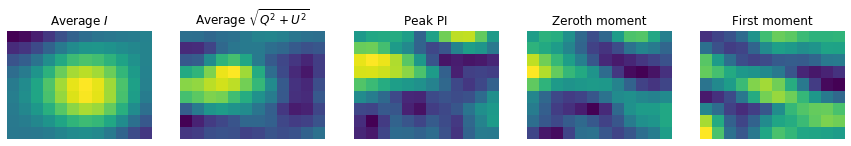

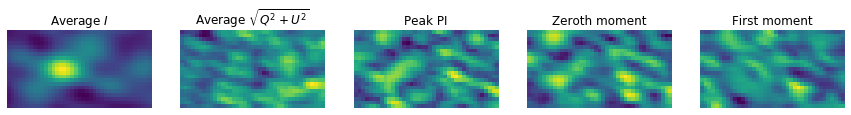

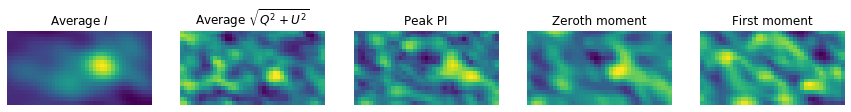

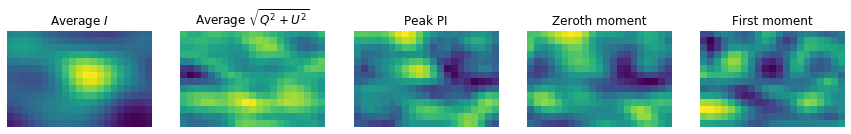

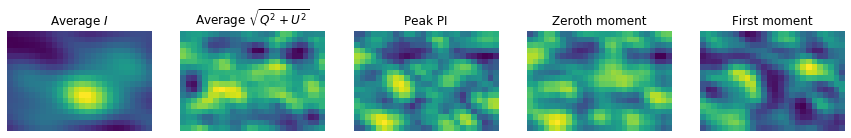

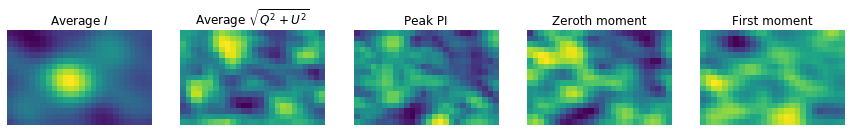

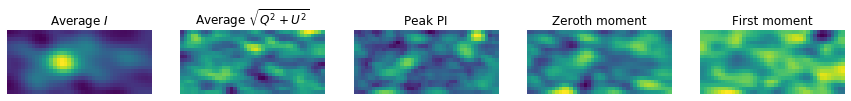

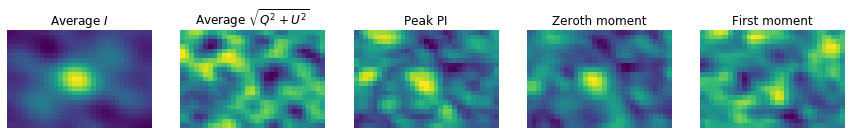

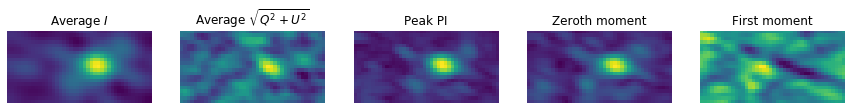

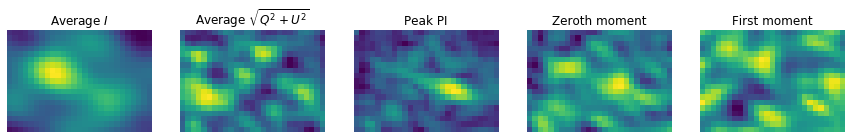

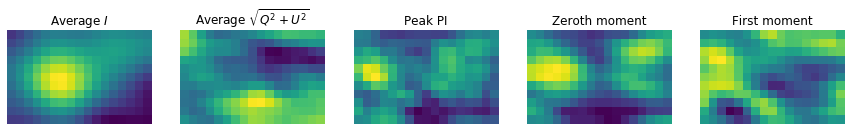

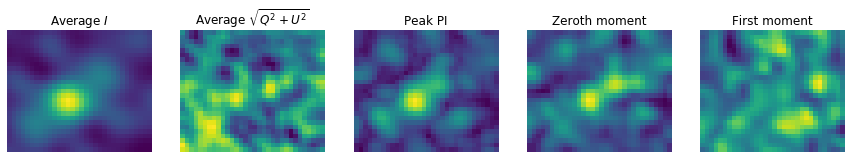

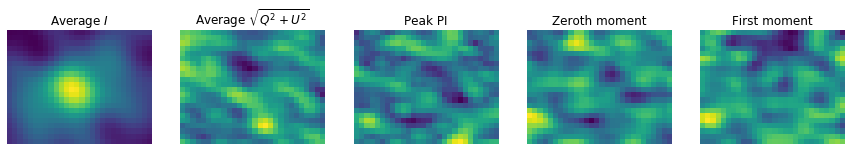

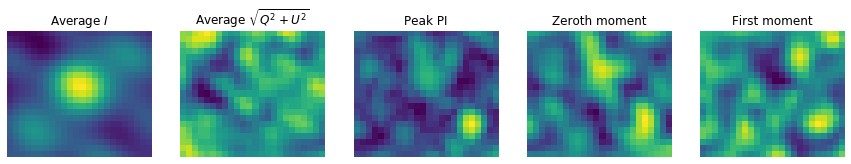

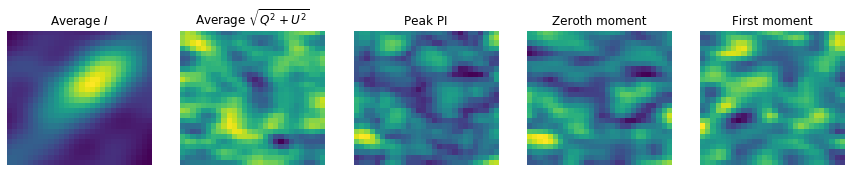

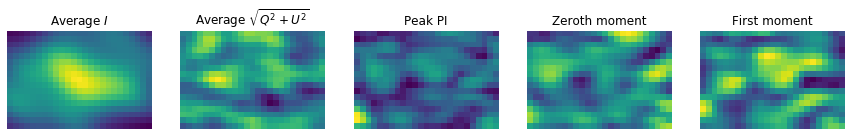

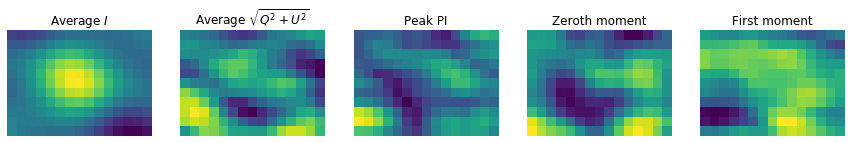

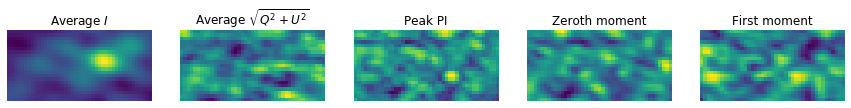

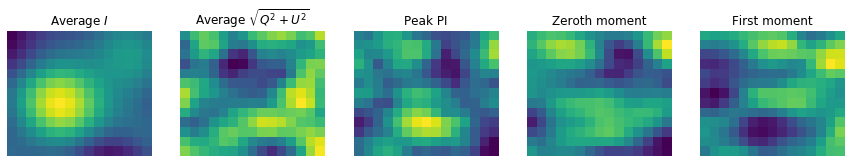

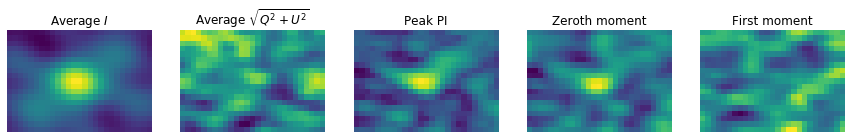

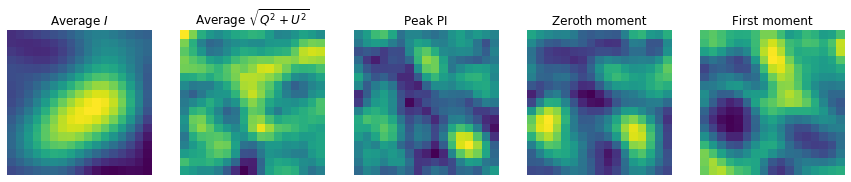

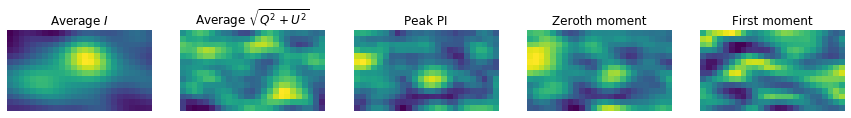

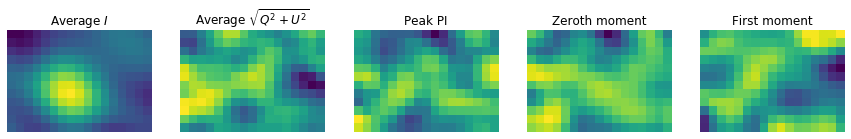

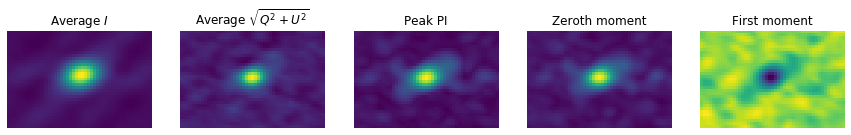

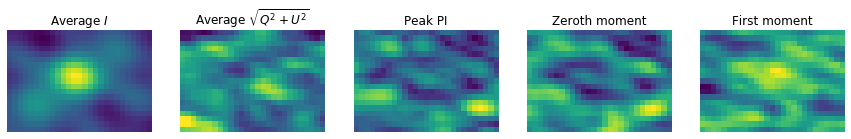

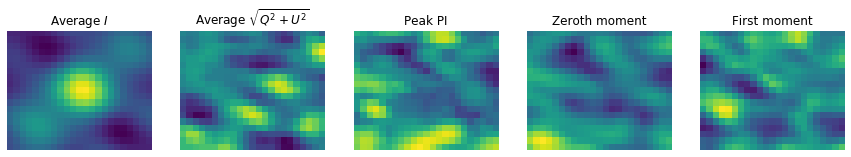

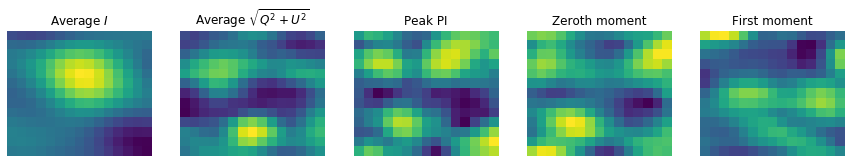

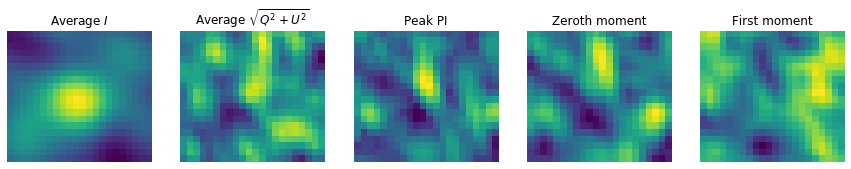

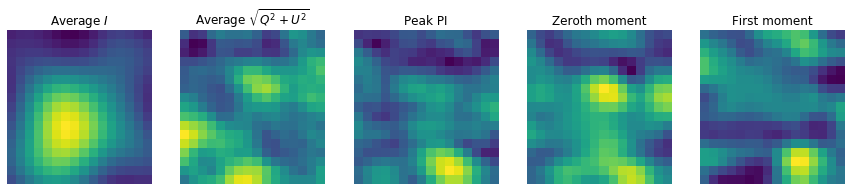

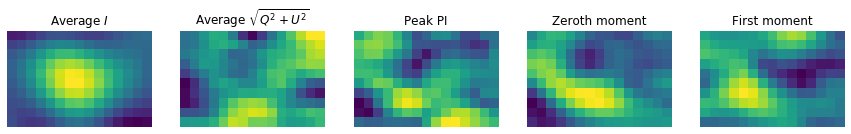

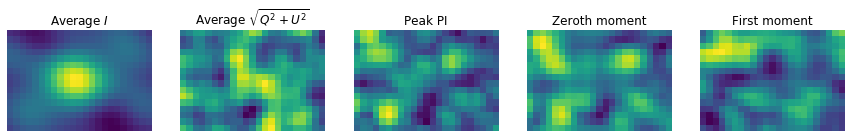

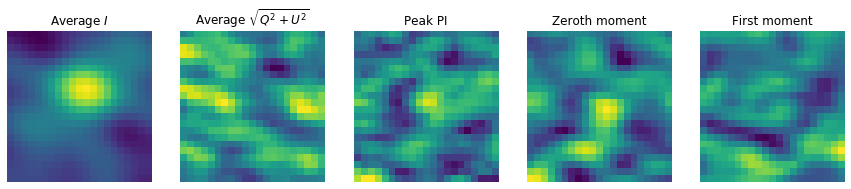

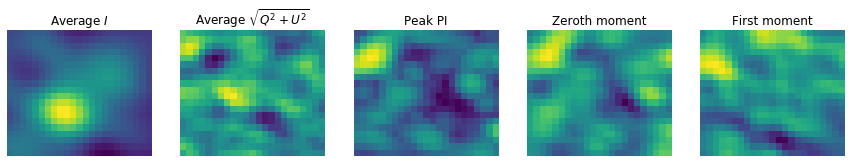

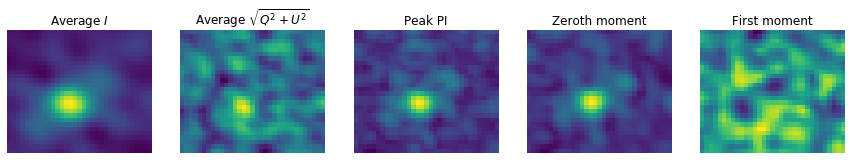

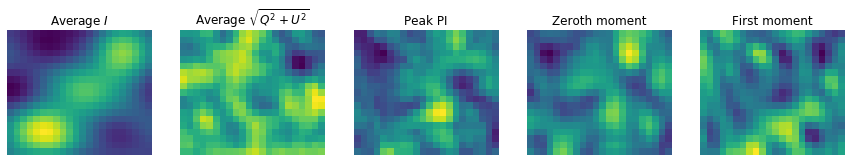

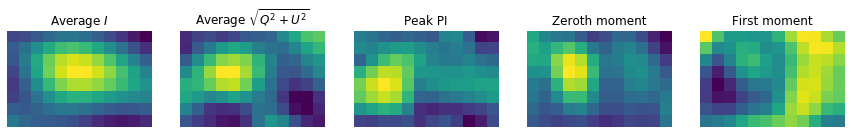

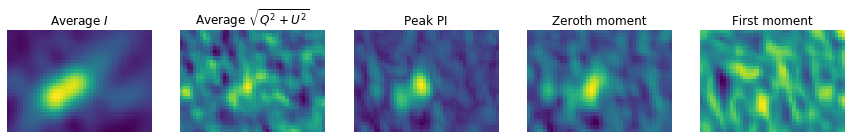

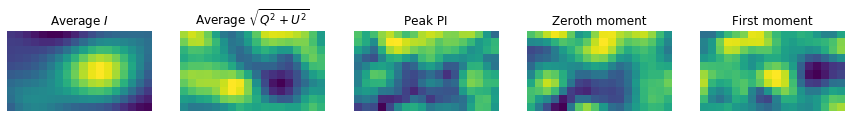

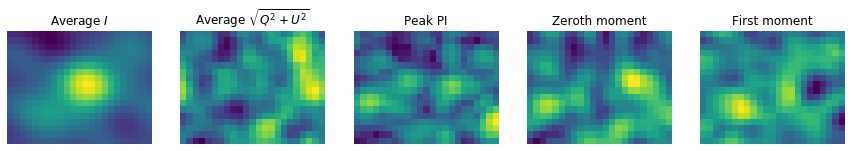

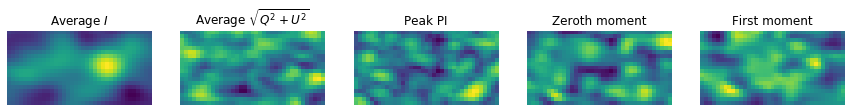

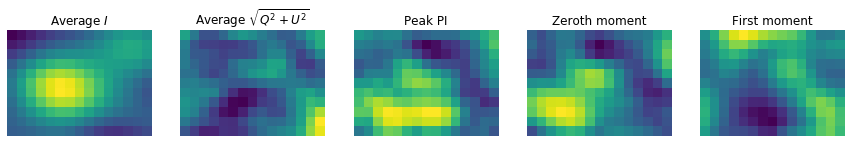

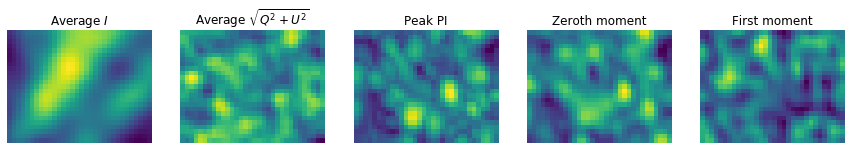

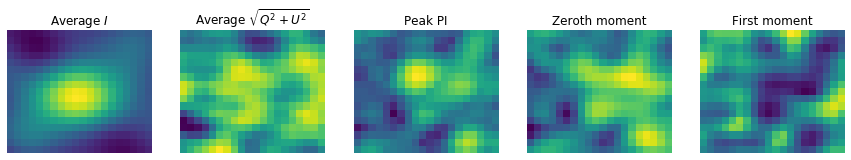

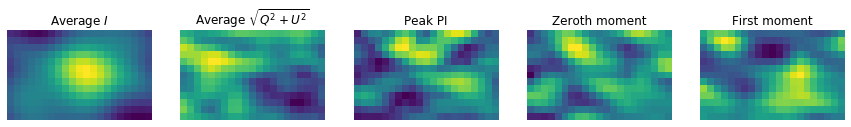

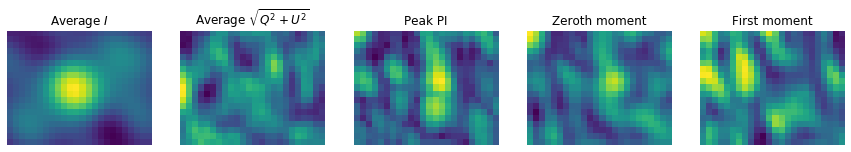

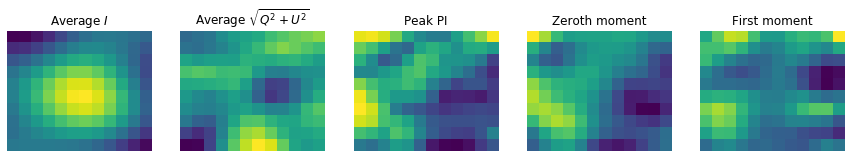

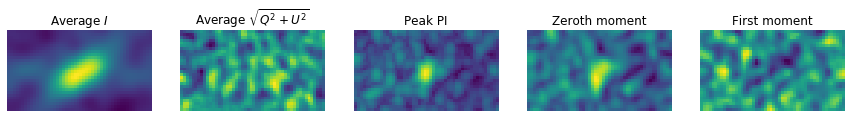

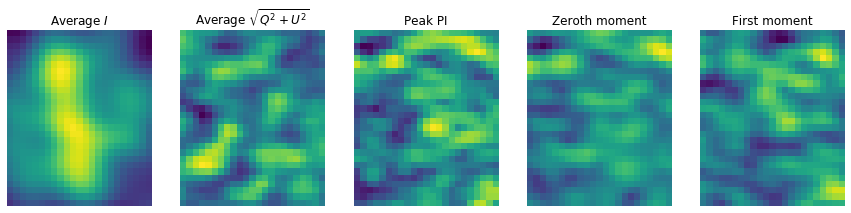

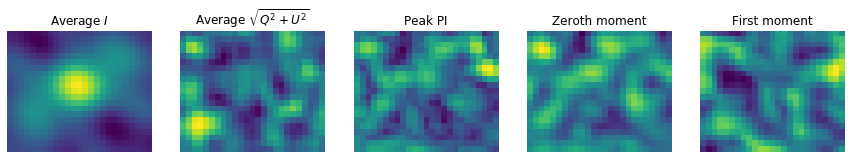

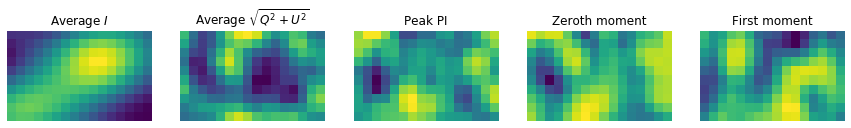

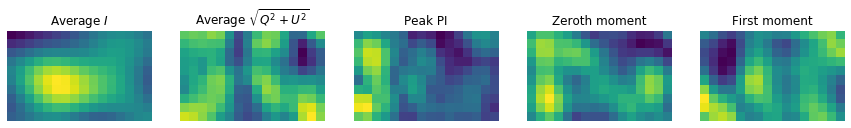

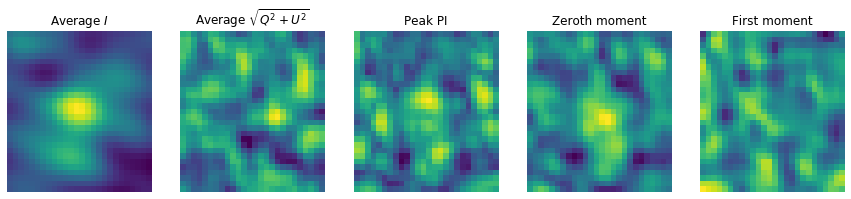

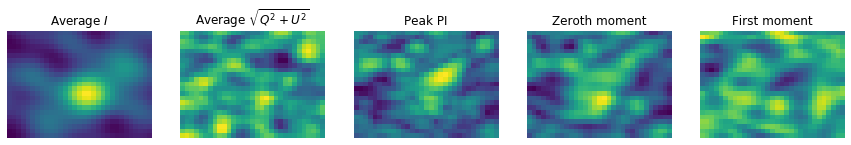

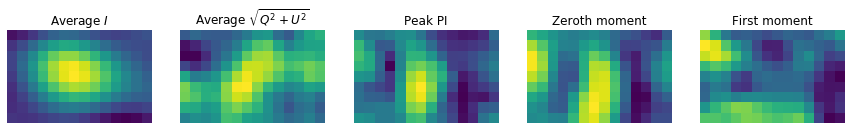

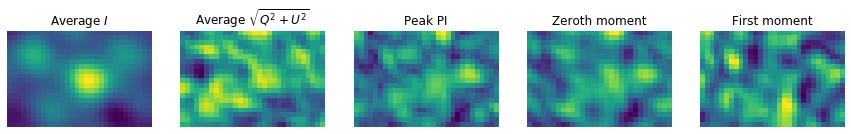

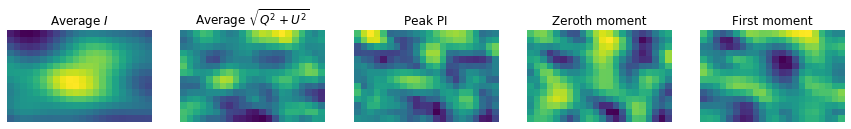

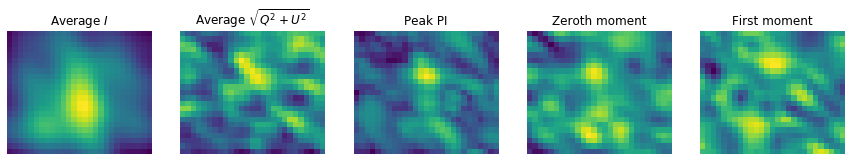

In [26]:
for i in range(len(ints)):
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 5, 1)
    plt.imshow(ints[i].mean(axis=0))
    plt.axis('off')
    plt.title('Average $I$')
    plt.subplot(1, 5, 2)
    plt.imshow(abs(pols[i]).mean(axis=0))
    plt.axis('off')
    plt.title('Average $\\sqrt{Q^2 + U^2}$')
    plt.subplot(1, 5, 3)
    plt.imshow(abs(rmsynths[i]).max(axis=0))
    plt.axis('off')
    plt.title('Peak PI')
    plt.subplot(1, 5, 4)
    plt.imshow(abs(rmsynths[i]).mean(axis=0))
    plt.axis('off')
    plt.title('Zeroth moment')
    plt.subplot(1, 5, 5)
    plt.imshow((abs(rmsynths[i]) * phis[:, None, None]).mean(axis=0))
    plt.axis('off')
    plt.title('First moment')
    plt.show()

In [24]:
Q[0].header['NAXIS2'] * Q[0].header['CDELT2']

2.8444444444442625

Based on the results so far,

- PyBDSF seems to be a better source finder than Aegean (at least on *source*-finding),
- RM synthesis to get the peak PI seems a much better, if expensive, way to get a polarised signal.

At the moment my recommendation would be to source-find on $I$ and then do RM synthesis of the cutout, and then do source-finding on that cutout. This depends a lot on sky density. It'd be nice if there was a good and fast way to tell if we should do RM synthesis or not.

### Extracting polarisation information

(Canberra)

I want to extract polarisation information for each object. We'll do this on a per-island basis, though it'd be nice to do this per-Gaussian (maybe later). The information I want is:

- polarised intensity
- polarisation angle
- fractional polarisation
- rotation measure (I'll fit a line to $\chi(\lambda^2)$)
- location of polarisation peak (I'll take the argmax)
- peak Faraday depth
- peak PI

For now we'll just pull this directly from the image. I suspect a better approach would be to source-find on the peak PI image, but we can do that later.

#### PyBDSF

In [392]:
pol_intensities = []
peak_locs = []
fractional_pols = []
island_ids = []
rm_linfits = []
peak_fdfs = []
fdf_at_peaks = []
for isl, rmsy, mask, inti, poli in zip(tqdm(img_mP_I.islands), rmsynths, masks, ints, pols):
    mask = ~mask
    assert isl.image.shape == inti.shape[1:]
    assert isl.image.shape == poli.shape[1:]
    mean_pol = abs(numpy.where(mask, poli, 0)).mean(axis=0)
    mean_int = (numpy.where(mask, inti, 0)).mean(axis=0)
    pol_intensities.append(mean_pol.sum())
    peak_loc = numpy.unravel_index(mean_pol.argmax(), mean_pol.shape)
    peak_loc = peak_loc[0] + isl.bbox[0].start, peak_loc[1] + isl.bbox[1].start
    peak_loc, = wcs.all_pix2world([peak_loc], 1)
    peak_locs.append(peak_loc)
    fractional_pols.append(mean_pol.sum() / mean_int.sum())
    
    # chi(lambda^2)
    wls = (299792458 / freqs) ** 2
    chis = numpy.arctan2(numpy.where(mask, poli, 0).imag.sum(axis=(1, 2)),
                         numpy.where(mask, poli, 0).real.sum(axis=(1, 2))) / 2
    # Fit a line to get the RM.
    # Hugely naïve.
    pf = numpy.polyfit(wls, chis, 1)
    rm = pf[0]
    rm_linfits.append(rm)
    
    # RM synthesis.
    rmsynth_spec = numpy.where(mask, rmsy, 0).sum(axis=(1, 2))
    peak_fdfs.append(phis[abs(rmsynth_spec).argmax()])
    fdf_at_peaks.append(abs(rmsynth_spec).max())
    
    island_ids.append(isl.island_id)

In [393]:
len(island_ids), len(pol_intensities), len(bdsf_cat_isle)

(189, 189, 189)

In [394]:
bdsf_cat_isle_with_pol = bdsf_cat_isle.set_index(' Isl_id').loc[island_ids]
print(len(bdsf_cat_isle_with_pol))
bdsf_cat_isle_with_pol['pol_int'] = pol_intensities
bdsf_cat_isle_with_pol['pol_peak_ra'] = [ra for ra, _ in peak_locs]
bdsf_cat_isle_with_pol['pol_peak_dec'] = [dec for _, dec in peak_locs]
bdsf_cat_isle_with_pol['pol_frac'] = fractional_pols
bdsf_cat_isle_with_pol['rm_linfit'] = rm_linfits
bdsf_cat_isle_with_pol['peak_fd'] = peak_fdfs
bdsf_cat_isle_with_pol['peak_pi'] = fdf_at_peaks

189


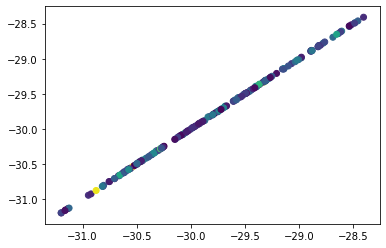

In [397]:
# plt.scatter(sorted(bdsf_cat_isle_with_pol[' DEC']),
#             sorted(bdsf_cat_isle_with_pol['pol_peak_dec']))
# plt.scatter(bdsf_cat_isle_with_pol[' DEC'],
#             bdsf_cat_isle_with_pol['pol_peak_dec'],
#             c=bdsf_cat_isle_with_pol['pol_int'])
# # bdsf_cat_isle_with_pol

# plt.scatter(bdsf_cat_isle_with_pol.peak_fd,
#             bdsf_cat_isle_with_pol.rm_linfit)
# plt.scatter(bdsf_cat_isle_with_pol.peak_pi,
#             bdsf_cat_isle_with_pol.pol_int)

In [413]:
# bdsf_cat_isle_with_pol.to_csv('/home/alger/possum/alger/hamburg/I_04.smoothed.mean.bdsf_isle.pol.csv')
Table.from_pandas(bdsf_cat_isle_with_pol).write(
    '/home/alger/possum/alger/hamburg/I_04.smoothed.mean.bdsf_isle.pol.fits')

#### Aegean

Aegean doesn't have island masks that I can find, so we'll do a cut at $4\sigma$. (I should be able to derive them from the contours, but this is a job for later.)

In [399]:
from AegeanTools import models
aegean_island_sources = [
    k for k in sf.sources if type(k) == models.IslandSource]

assert len(aegean_island_sources) == len(aegean_islands)

In [400]:
aegean_pol_intensities = []
# aegean_peak_locs = []
aegean_fractional_pols = []
aegean_island_ids = []
aegean_rm_linfits = []
aegean_peak_fdfs = []
aegean_fdf_at_peaks = []
for cutout_i, cutout_p, (_, isl) in zip(
        tqdm(aegean_intensity_cutouts),
        aegean_polarised_cutouts,
        aegean_islands.iterrows()):
    mask = cutout_i > isl.local_rms * 4
    
    bbox = aegean_island_sources[0].extent
    mean_pol = abs(numpy.where(mask, cutout_p, 0)).mean(axis=0)
    mean_int = (numpy.where(mask, cutout_i, 0)).mean(axis=0)
    aegean_pol_intensities.append(mean_pol.sum())
#     peak_loc = numpy.unravel_index(mean_pol.argmax(), mean_pol.shape)
#     peak_loc = peak_loc[0] + isl.bbox[0].start, peak_loc[1] + isl.bbox[1].start
#     peak_loc, = wcs.all_pix2world([peak_loc], 1)
#     peak_locs.append(peak_loc)
    aegean_fractional_pols.append(mean_pol.sum() / mean_int.sum())
    
    # chi(lambda^2)
    wls = (299792458 / freqs) ** 2
    chis = numpy.arctan2(numpy.where(mask, cutout_p, 0).imag.sum(axis=(1, 2)),
                         numpy.where(mask, cutout_p, 0).real.sum(axis=(1, 2))) / 2
    # Fit a line to get the RM.
    # Hugely naïve.
    pf = numpy.polyfit(wls, chis, 1)
    rm = pf[0]
    aegean_rm_linfits.append(rm)
    
    # RM synthesis.
    rmsy = util_RM.do_rmsynth_planes(
        cutout_p.real, cutout_p.imag, (299792458 / freqs) ** 2, phis)[0]
    rmsynth_spec = numpy.where(mask, rmsy, 0).sum(axis=(1, 2))
    aegean_peak_fdfs.append(phis[abs(rmsynth_spec).argmax()])
    aegean_fdf_at_peaks.append(abs(rmsynth_spec).max())
    
    aegean_island_ids.append(isl.island)

In [406]:
aegean_islands_with_pol = aegean_islands.set_index('island').loc[aegean_island_ids]
aegean_islands_with_pol['pol_int'] = aegean_pol_intensities
# aegean_islands_with_pol['pol_peak_ra'] = [ra for ra, _ in aegean_peak_locs]
# aegean_islands_with_pol['pol_peak_dec'] = [dec for _, dec in aegean_peak_locs]
aegean_islands_with_pol['pol_frac'] = aegean_fractional_pols
aegean_islands_with_pol['rm_linfit'] = aegean_rm_linfits
aegean_islands_with_pol['peak_fd'] = aegean_peak_fdfs
aegean_islands_with_pol['peak_pi'] = aegean_fdf_at_peaks
# aegean_islands_with_pol
# [i in aegean_islands.set_index('island').index for i in aegean_island_ids]

In [36]:
from astropy.table import Table

In [412]:

Table.from_pandas(aegean_islands_with_pol).write(
    '/home/alger/possum/alger/hamburg/I_04.smoothed.mean.aegean_isle.pol.fits')

In [ ]:
/home/alger/possum/alger/hamburg/I_04.smoothed.mean.aegean_isle.pol.fits
/home/alger/possum/alger/hamburg/I_04.smoothed.mean.bdsf_isle.pol.fits

In [43]:
aegean_islands_with_pol = Table(fits.open('/home/alger/possum/alger/hamburg/I_04.smoothed.mean.aegean_isle.pol.fits')[1].data).to_pandas()
bdsf_islands_with_pol = Table(fits.open('/home/alger/possum/alger/hamburg/I_04.smoothed.mean.bdsf_isle.pol.fits')[1].data).to_pandas()

In [56]:
aegean_islands_with_pol.columns

Index(['components', 'background', 'local_rms', 'ra_str', 'dec_str', 'ra',
       'dec', 'peak_flux', 'int_flux', 'err_int_flux', 'eta', 'x_width',
       'y_width', 'max_angular_size', 'pa', 'pixels', 'area', 'beam_area',
       'flags', 'uuid', 'pol_int', 'pol_frac', 'rm_linfit', 'peak_fd',
       'peak_pi'],
      dtype='object')

Text(0, 0.5, 'Island count')

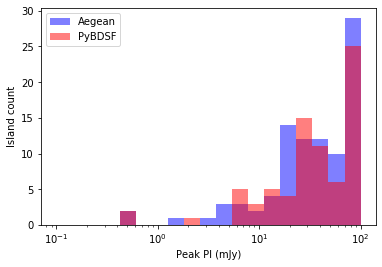

In [72]:
bins = numpy.logspace(-1, 2, 20)
plt.hist(aegean_islands_with_pol.peak_fd, bins=bins, alpha=0.5, color='blue', label='Aegean')
plt.hist(bdsf_islands_with_pol.peak_fd, bins=bins, alpha=0.5, color='red', label='PyBDSF')
plt.xscale('log')
plt.legend()
plt.xlabel('Peak PI (mJy)')
plt.ylabel('Island count')
# plt.savefig('peakpi.pdf')

## Aegean $\times$ PyBDSF

What we're really interested in is the difference in polarisation properties pulled out by Aegean and PyBDSF. Let's cross-match islands from Aegean with islands from PyBDSF and then find polarised objects in each. We can do RM synthesis on the cutouts to detect a signal. We'll do a really naïve two-way directed nearest-neighbour positional match. We don't get a single island coordinate from PyBDSF — instead just one per component — so we'll average those to get a coordinate for each island.

In [87]:
aegean_coords = SC(ra=aegean_islands['ra'], dec=aegean_islands['dec'], unit='deg')

In [88]:
ras = []
decs = []
island_ids = []
for i, row in bdsf_cat_isle.iloc[2:].groupby(' Isl_id'):
    ras.append(row[' RA'].mean())
    decs.append(row[' DEC'].mean())
    island_ids.append(i)
bdsf_coords = SC(ra=ras, dec=decs, unit='deg')

NameError: name 'bdsf_cat_isle' is not defined

In [89]:
aegean_into_bdsf_idx, aegean_into_bdsf_sep, _ = aegean_coords.match_to_catalog_sky(bdsf_coords)

NameError: name 'bdsf_coords' is not defined

In [100]:
bdsf_into_aegean_idx, bdsf_into_aegean_sep, _ = bdsf_coords.match_to_catalog_sky(aegean_coords)

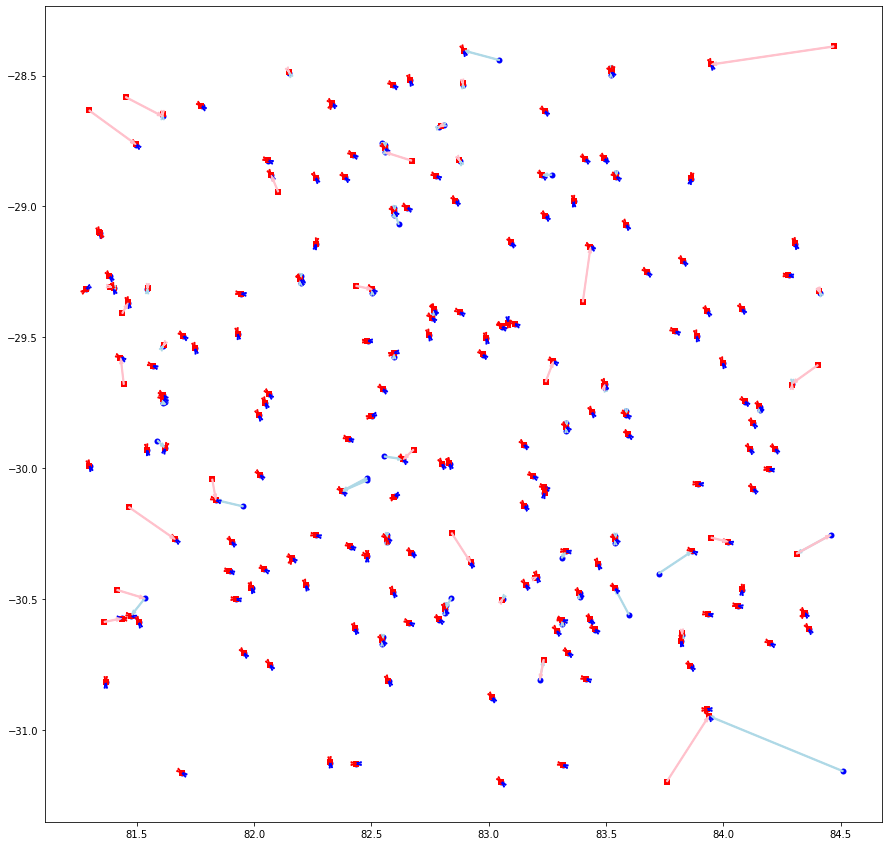

In [101]:
plt.figure(figsize=(15, 15))
plt.scatter(aegean_coords.ra, aegean_coords.dec, c='blue', marker='o', linewidth=0)
plt.scatter(bdsf_coords.ra, bdsf_coords.dec, c='red', marker='s', linewidth=0)
for a, b, s in zip(aegean_coords, aegean_into_bdsf_idx, aegean_into_bdsf_sep):
    plt.arrow(a.ra.deg, a.dec.deg, bdsf_coords[b].ra.deg - a.ra.deg, bdsf_coords[b].dec.deg - a.dec.deg,
              color='blue' if s.arcmin < 0.25 else 'lightblue', length_includes_head=True, width=0.005)
for a, b, s in zip(bdsf_coords, bdsf_into_aegean_idx, bdsf_into_aegean_sep):
    plt.arrow(a.ra.deg, a.dec.deg, aegean_coords[b].ra.deg - a.ra.deg, aegean_coords[b].dec.deg - a.dec.deg,
              color='red' if s.arcmin < 0.25 else 'pink', length_includes_head=True, width=0.005)

I've used a very simple $0.25'$ cut. Now for each of these, we'll calculate the polarised intensity. To do this, we'll mask the polarised image and sum all the pixels. PyBDSF provides a mask anyway, while Aegean gives us the local RMS and we can mask at $3 \sigma$.

In [85]:
bdsf_total_polarisation = []
for i in tqdm(island_ids):
    cutout_i = img_mP.islands[i]
    cutout_p = bdsf_polarised_cutouts[i]
    bdsf_total_polarisation.append(numpy.nansum(numpy.where(
         ~cutout_i.mask_active,
        abs(cutout_p).mean(axis=0),
        numpy.nan)))

NameError: name 'island_ids' is not defined

In [86]:
aegean_total_polarisation = []
for cutout_i, cutout_p, (_, isl) in zip(
        aegean_intensity_cutouts, aegean_polarised_cutouts, aegean_islands.iterrows()):
    mask = cutout_i > isl.local_rms * 3
    aegean_total_polarisation.append(numpy.nansum(numpy.where(
        mask,
        abs(cutout_p).mean(axis=0),
        numpy.nan)))

Regardless of what these values *are*, we can now compare between the source-finders. We'll do this *very* naïvely and not aggregate sources; we'll just plot one point per neighbour.

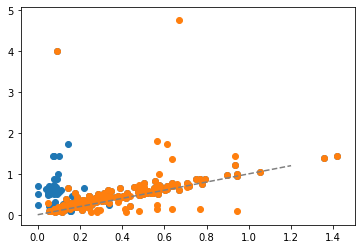

In [114]:
plt.scatter(aegean_total_polarisation, numpy.array(bdsf_total_polarisation)[aegean_into_bdsf_idx])
plt.scatter(numpy.array(aegean_total_polarisation)[bdsf_into_aegean_idx], bdsf_total_polarisation)
plt.plot([0, 1.2], [0, 1.2], linestyle='--', color='grey')

We can then threshold to find about 15 sources.

In [77]:
numpy.array(aegean_total_polarisation) > 0.8

NameError: name 'aegean_total_polarisation' is not defined

# Average P

Now let's compute the average polarised intensity and source-find on that. It will have Ricean noise so we expect source-finders to do worse than on average I.

In [95]:
smoothed_path_Q = f'/data/mash/alger/Q_{beam}.smoothed.mean.fits'
smoothed_path_U = f'/data/mash/alger/U_{beam}.smoothed.mean.fits'
smoothed_path_P = f'/data/mash/alger/P_{beam}.smoothed.mean.fits'
resmooth = False
if resmooth:
    smoothed_Q = smooth_cube(Q)
    smoothed_U = smooth_cube(U)

    # It's useful to have these around for later since they take a while to make.
    total_Q_header = Q[0].header.copy()
    total_Q_fits = fits.PrimaryHDU(data=smoothed_Q, header=total_Q_header)
    total_Q_fits.writeto(smoothed_path_Q, overwrite=True)

    total_U_header = U[0].header.copy()
    total_U_fits = fits.PrimaryHDU(data=smoothed_U, header=total_U_header)
    total_U_fits.writeto(smoothed_path_U, overwrite=True)

    # Now we can find the per-channel P.
    total_P = numpy.zeros((4096, 4096))
    for channel in tqdm(range(288)):
        total_P += numpy.sqrt(numpy.power(smoothed_Q[channel], 2) + numpy.power(smoothed_U[channel], 2))

    total_P /= 288

    assert len(smoothed_Q) == 288

    total_P.shape

    
    total_P_header = I[0].header.copy()
    total_P_header['NAXIS3'] = 0
    total_P_header['NAXIS4'] = 0
    total_P_fits = fits.PrimaryHDU(data=total_P, header=total_P_header)
    total_P_fits.writeto(smoothed_path_P, overwrite=True)
else:
    total_P = fits.open(smoothed_path_P, mode='denywrite')

## Aegean

In [11]:
BANE.filter_image(smoothed_path_P, smoothed_path_P, cores=8)

In [13]:
%%bash
ls /data/mash/alger/P_*

/data/mash/alger/P_04.smoothed.mean.fits
/data/mash/alger/P_04.smoothed.mean.fits_bkg.fits
/data/mash/alger/P_04.smoothed.mean.fits_rms.fits


It's probably worth looking at the bkg and rms images, since this is one place where Gaussian/Ricean noise fits in.

In [14]:
bkg = fits.open('/data/mash/alger/P_04.smoothed.mean.fits_bkg.fits', mode='denywrite')

In [15]:
rms = fits.open('/data/mash/alger/P_04.smoothed.mean.fits_rms.fits', mode='denywrite')

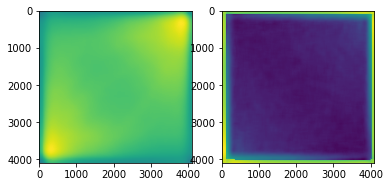

In [22]:
fig, (a, b) = plt.subplots(1, 2)
a.imshow(bkg[0].data)
b.imshow(rms[0].data ** 0.03)

Very high RMS at the edges; not sure what to make of that.

In [23]:
# Hacked from AegeanTools/scripts/Aegean.
csv_path = f'/home/alger/possum/alger/hamburg/P_{beam}.smoothed.mean.csv'
log = logging.getLogger("Aegean")
log.setLevel(logging.INFO)
sf = SourceFinder(log=log)
cores = 1
filename = smoothed_path_P
hdu_index = 0
lat = -26.6970
basename = os.path.splitext(filename)[0]
backgroundimg = '/data/mash/alger/P_04.smoothed.mean.fits_bkg.fits'
noiseimg = '/data/mash/alger/P_04.smoothed.mean.fits_rms.fits'
tables = csv_path
if not check_table_formats(tables):
    log.critical("One or more output table formats are not supported: Exiting")
    print(show_formats())
    raise ValueError()

log.info("Finding sources.")
found = sf.find_sources_in_image(filename, hdu_index=hdu_index, cores=cores, rmsin=noiseimg,
                                 bkgin=backgroundimg,
                                 doislandflux=True,
                                 nonegative=False, nopositive=False,
                                 lat=lat)

sources = sf.sources
log.info("found {0} sources total".format(len(sources)))
if len(sources) > 0 and tables:
    for t in tables.split(','):
        save_catalog(t, sources)

INFO:Aegean:HDF5 is not supported by your environment
INFO:Aegean:Finding sources.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must no

In [73]:
aegean_islands_P = pandas.read_csv('/home/alger/possum/alger/hamburg/P_04.smoothed.mean_isle.csv')
aegean_components_P = pandas.read_csv('/home/alger/possum/alger/hamburg/P_04.smoothed.mean_comp.csv')

In [92]:
len(aegean_islands_P), len(aegean_components_P)

(16, 16)

In [75]:
wcs = WCS(I[0].header).dropaxis(3).dropaxis(2)

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not

In [76]:
aegean_polarised_cutouts_P = []
for i, island in tqdm(aegean_islands_P.iterrows(), total=len(aegean_islands_P)):
    ra, dec = island.ra, island.dec
    (y, x), = wcs.all_world2pix([[ra, dec]], 1).astype(int)
    xr = max(island.x_width // 2, 6)  # Particularly small widths tend to be wrong.
    yr = max(island.y_width // 2, 6)
    bbox = (slice(None, None), 0, slice(x - xr, x + xr), slice(y - yr, y + yr))
    cutout_Q = Q[0].data[bbox]
    cutout_U = U[0].data[bbox]
    aegean_polarised_cutouts_P.append(cutout_Q + 1j * cutout_U)

In [77]:
aegean_intensity_cutouts_P = []
for i, island in tqdm(aegean_islands_P.iterrows(), total=len(aegean_islands_P)):
    ra, dec = island.ra, island.dec
    (y, x), = wcs.all_world2pix([[ra, dec]], 1).astype(int)
    xr = max(island.x_width // 2, 6)
    yr = max(island.y_width // 2, 6)
    bbox = (slice(x - xr, x + xr), slice(y - yr, y + yr))
    cutout = total_I[bbox]
    aegean_intensity_cutouts_P.append(cutout)

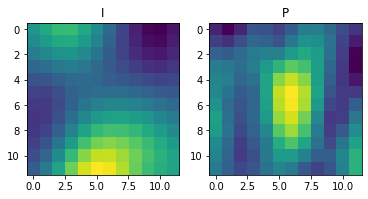

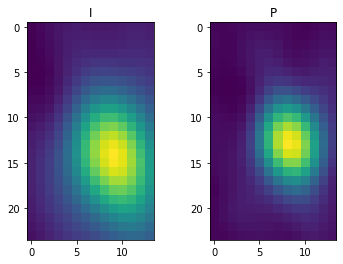

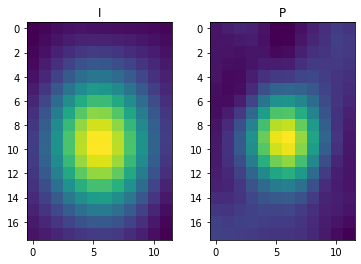

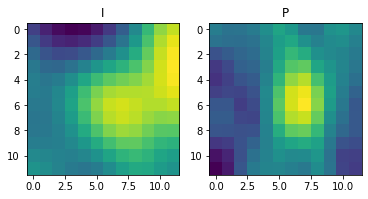

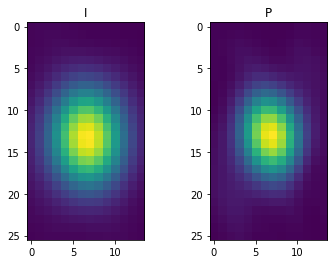

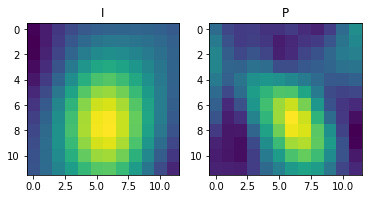

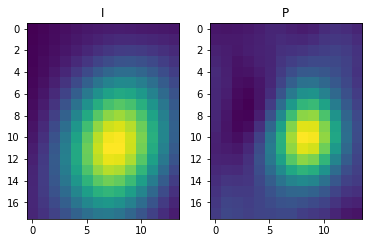

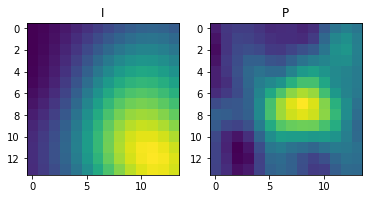

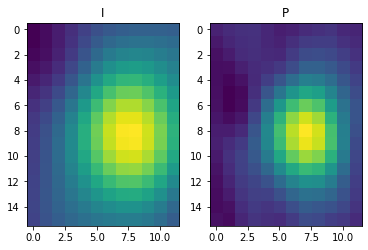

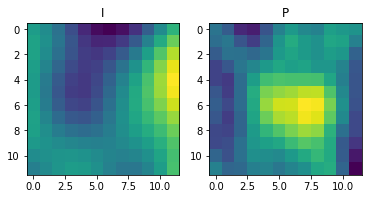

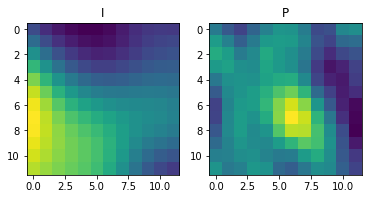

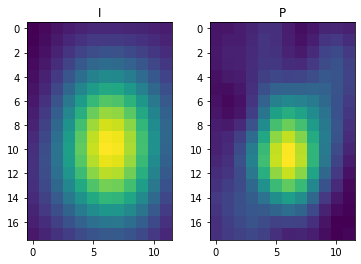

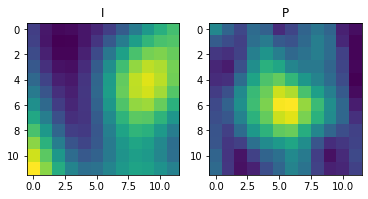

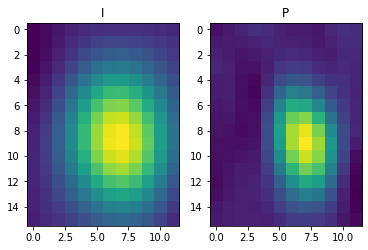

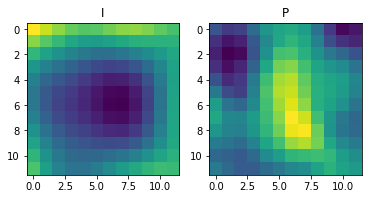

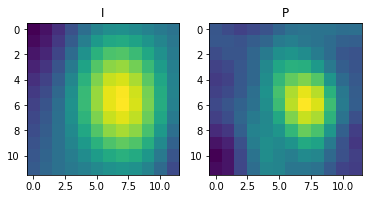

In [78]:
for cutout_i, cutout_p, (_, isl) in zip(
        aegean_intensity_cutouts_P, aegean_polarised_cutouts_P, aegean_islands_P.iterrows()):
    mask = abs(cutout_p).mean(axis=0) > isl.local_rms * 2
    plt.subplot(1, 2, 1)
    plt.imshow(numpy.where(mask, cutout_i, numpy.nan))
    plt.title('I')
    plt.subplot(1, 2, 2)
    plt.imshow(numpy.where(mask, abs(cutout_p).mean(axis=0), numpy.nan))
    plt.title('P')
    plt.show()

## PyBDSF

In [96]:
#   flag_maxsnr .......... 1.5 : Flag Gaussian if peak is greater than flag_maxsnr
#                                times max value in island
#   flag_minsize_bm ...... 0.7 : Flag Gaussian if flag_smallsrc = True and area
#                                smaller than flag_minsize_bm times beam area
#   flag_minsnr .......... 0.9

img_mP = bdsf.process_image(
    smoothed_path_P,
    rms_box=(100, 20),
    thresh='hard',
    thresh_isl=3.0,
    thresh_pix=5.0,
    incl_empty=True,

    flag_maxsnr=5,
    flag_minsnr=0,
    flag_minsize_bm=0)

--> Opened '/data/mash/alger/P_04.smoothed.mean.fits'
Image size .............................. : (4096, 4096) pixels
Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (5.91619e-03, 4.38077e-03, -0.7) degrees
Frequency of image ...................... : 743.991 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : 4805.151 Jy
--> Calculating background rms and mean images
Using user-specified rms_box ............ : (100, 20) pixels
--> Variation in rms image significant
--> Using 2D map for background rms
--> Variation in mean image significant
--> Using 2D map for background mean
Min/max values of background rms map .... : (4.33e-04, 7.72e-03) Jy/beam
Min/max values of background mean map ... : (3.44e-03, 2.41e-02) Jy/beam
Minimum number of pixels per island ..... : 20
Number of islands found ................. : 14


Fitting islands with Gaussians .......... : [|-------------] 0/14/Fitting islands with Gaussians .......... : [=/------------] 1/14/Fitting islands with Gaussians .......... : [=/------------] 1/14\Fitting islands with Gaussians .......... : [===\----------] 3/14\Fitting islands with Gaussians .......... : [===\----------] 3/14//Fitting islands with Gaussians .......... : [=====/--------] 5/14Fitting islands with Gaussians .......... : [=====/--------] 5/14\\Fitting islands with Gaussians .......... : [=======\------] 7/14Fitting islands with Gaussians .......... : [=======\------] 7/14/Fitting islands with Gaussians .......... : [=========/----] 9/14-Fitting islands with Gaussians .......... : [==========----] 10/14\Fitting islands with Gaussians .......... : [===========\--] 11/14|Fitting islands with Gaussians .......... : [============|-] 12/14/Fitting islands with Gaussians .......... : [=============/] 13/14Fitting islands with Gaussians .......... : [==============] 14/14Fitting

Total number of Gaussians fit to image .. : 13
Total flux density in model ............. : 0.394 Jy


--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 13
    Island #12 (x=2983, y=371)
Please check this island. If it is a valid island and
should be fit, try adjusting the flagging options (use
show_fit with "ch0_flagged=True" to see the flagged Gaussians)
or enabling the wavelet module (with "atrous_do=True").
To include empty islands in output source catalogs, set
incl_empty=True in the write_catalog task.


Note that fitting with `atrous_do` seems to find 522 islands, which is way too many islands. A lot of perfectly legit-looking sources are masked, so we'll include empty islands here.

In [97]:
len(aegean_intensity_cutouts_P)

16

NOTE -- With the mouse pointer in plot window:
  Press "i" ........ : Get integrated flux densities and mean rms
                       values for the visible portion of the image
  Press "m" ........ : Change min and max scaling values
  Press "n" ........ : Show / hide island IDs
  Press "0" ........ : Reset scaling to default
  Click Gaussian ... : Print Gaussian and source IDs (zoom_rect mode, 
                       toggled with the "zoom" button and indicated in 
                       the lower right corner, must be off)
________________________________________________________________________


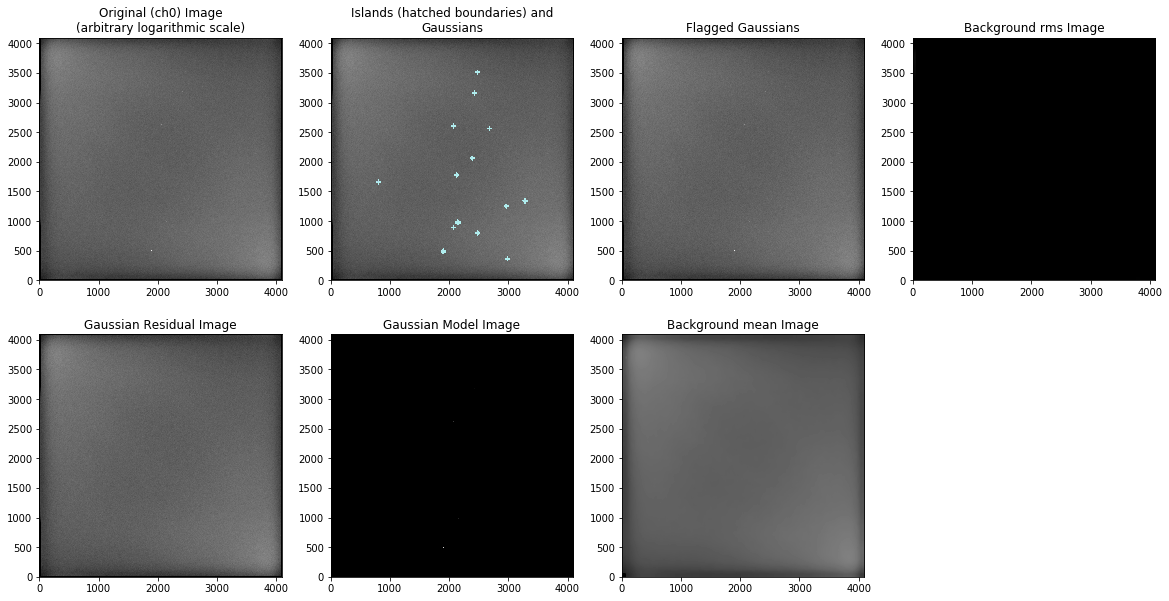

In [98]:
bdsf_show_fit(img_mP, ch0_flagged=True)

In [100]:
bdsf_cat_path_P = '/home/alger/possum/alger/hamburg/P_04.smoothed.mean.bdsf_gaul.csv'
img_mP.write_catalog(outfile=bdsf_cat_path_P, format='csv', catalog_type='gaul', clobber=True, incl_empty=True)

bdsf_cat_path_isle_P = '/home/alger/possum/alger/hamburg/P_04.smoothed.mean.bdsf_isle.csv'
img_mP.write_catalog(outfile=bdsf_cat_path_isle_P, format='csv', catalog_type='srl', clobber=True, incl_empty=True)

--> Wrote ASCII file '/home/alger/possum/alger/hamburg/P_04.smoothed.mean.bdsf_gaul.csv'
--> Wrote ASCII file '/home/alger/possum/alger/hamburg/P_04.smoothed.mean.bdsf_isle.csv'


True

In [101]:
bdsf_cat_isle_P = pandas.read_csv(bdsf_cat_path_isle_P, skiprows=5)
bdsf_cat_gaul_P = pandas.read_csv(bdsf_cat_path_P, skiprows=5)

In [102]:
bdsf_polarised_cutouts_P = []
for island in tqdm(img_mP.islands):
    bbox = (slice(None, None), 0) + tuple(island.bbox[::-1])
    cutout_Q = Q[0].data[bbox]
    cutout_U = U[0].data[bbox]
    bdsf_polarised_cutouts_P.append(numpy.transpose(cutout_Q + 1j * cutout_U, (0, 2, 1)))

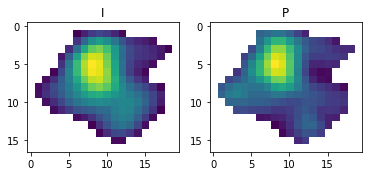

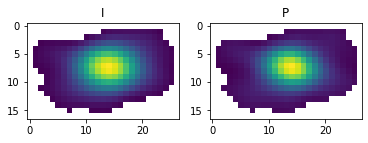

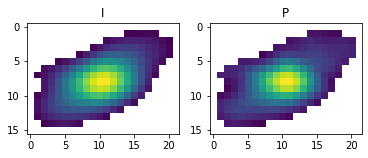

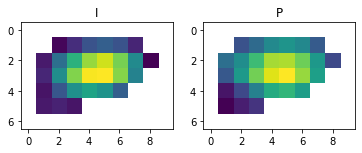

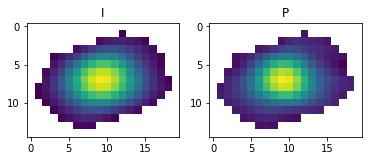

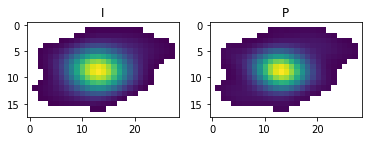

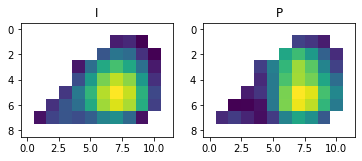

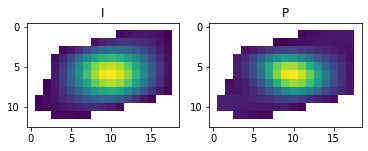

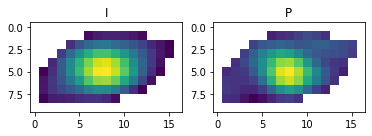

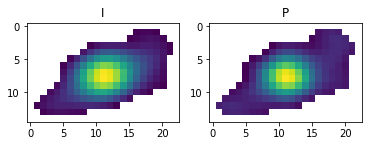

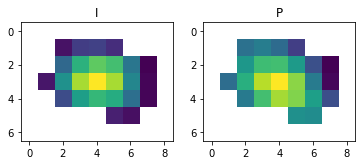

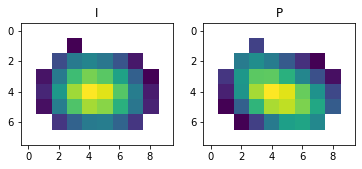

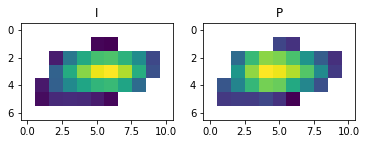

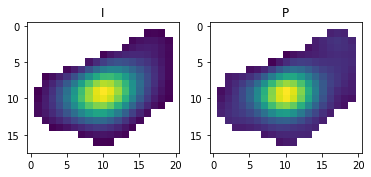

In [103]:
for cutout_i, cutout_p in zip(img_mP.islands, bdsf_polarised_cutouts_P):
    plt.subplot(1, 2, 1)
    plt.imshow(numpy.where(
         ~cutout_i.mask_active,
        cutout_i.image,
        numpy.nan))
    plt.title('I')
    plt.subplot(1, 2, 2)
    plt.imshow(numpy.where(
         ~cutout_i.mask_active,
        abs(cutout_p).mean(axis=0),
        numpy.nan))
    plt.title('P')
    plt.show()

## Aegean $\times$ PyBDSF

Now we can compare these directly.

In [107]:
aegean_coords_P = SC(ra=aegean_islands_P['ra'], dec=aegean_islands_P['dec'], unit='deg')

In [108]:
ras = []
decs = []
island_ids_P = []
for i, row in bdsf_cat_isle_P.groupby(' Isl_id'):
    ras.append(row[' RA'].mean())
    decs.append(row[' DEC'].mean())
    island_ids_P.append(i)
bdsf_coords_P = SC(ra=ras, dec=decs, unit='deg')

In [109]:
len(img_mP.islands)

14

In [110]:
aegean_into_bdsf_idx_P, aegean_into_bdsf_sep_P, _ = aegean_coords_P.match_to_catalog_sky(bdsf_coords_P)

In [111]:
bdsf_into_aegean_idx_P, bdsf_into_aegean_sep_P, _ = bdsf_coords_P.match_to_catalog_sky(aegean_coords_P)

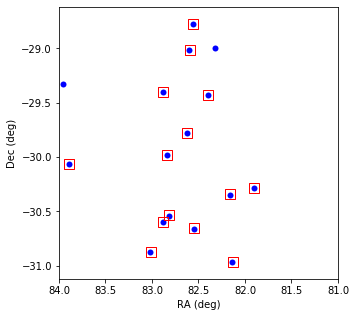

In [121]:
plt.figure(figsize=(5, 5))
plt.scatter(aegean_coords_P.ra, aegean_coords_P.dec, c='blue', marker='o', linewidth=0)
plt.scatter(bdsf_coords_P.ra, bdsf_coords_P.dec, edgecolor='red', s=100, marker='s', linewidth=1, facecolor='None')
plt.xlim(84, 81)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.savefig('bdsf_aegean_p_match.pdf')

In [131]:
bdsf_cat_isle_P

# Source_id   Isl_id         RA      E_RA        DEC     E_DEC  \
0             0        0  83.893170  0.000536 -30.061482  0.000497   
1             1        1  83.014962  0.000018 -30.876495  0.000037   
2             2        2  82.876364  0.000067 -29.404099  0.000129   
3             3        3  82.876347  0.000224 -30.594237  0.000587   
4             4        4  82.832898  0.000058 -29.981674  0.000113   
5             5        5  82.814382  0.000007 -30.537537  0.000015   
6             6        6  82.624284  0.000574 -29.782680  0.000737   
7             7        7  82.596138  0.000040 -29.018513  0.000105   
8             8        8  82.557415  0.000129 -28.777622  0.000328   
9             9        9  82.546338  0.000055 -30.656993  0.000113   
10           10       10  82.394777  0.000223 -29.432393  0.000434   
11           11       11  82.160793  0.000208 -30.344303  0.000339   
12           12       13  81.903726  0.000047 -30.281069  0.000089   
13           -1       12  82.133458  0.000000 -30.961861  0.000000   

     Total_flux   E_Total_flux   Peak_flux   E_Peak_flux  ...  \
0      0.017324       0.002753    0.005100      0.000642  ...   
1      0.075392       0.001329    0.061785      0.000657  ...   
2      0.023710       0.001314    0.018779      0.000624  ...   
3      0.003019       0.001004    0.003567      0.000610  ...   
4      0.018115       0.001109    0.016783      0.000597  ...   
5      0.170523       0.001311    0.154081      0.000694  ...   
6      0.005301       0.001659    0.002979      0.000635  ...   
7      0.017674       0.001015    0.019364      0.000595  ...   
8      0.007346       0.001126    0.006728      0.000588  ...   
9      0.021042       0.001230    0.020471      0.000670  ...   
10     0.002049       0.000700    0.002911      0.000494  ...   
11     0.003590       0.000948    0.004594      0.000635  ...   
12     0.029310       0.001306    0.025871      0.000674  ...   
13     0.000000       0.000000    0.023628      0.000000  ...   

     E_DC_Min_img_plane   DC_PA_img_plane   E_DC_PA_img_plane  \
0              0.000994        119.041480           25.024962   
1              0.000041          8.969587            1.261099   
2              0.000112         32.164874            3.106798   
3              0.000456          0.000000           15.651664   
4              0.000132         28.854791            4.702906   
5              0.000017          3.845837            0.631634   
6              0.001103         46.286511           32.994048   
7              0.000090          0.000000            3.195286   
8              0.000276          0.000000            8.537051   
9              0.000102          0.000000            3.431733   
10             0.000512          0.000000           24.310022   
11             0.000481          0.000000           25.912164   
12             0.000091         35.090348            3.355196   
13             0.000000          0.000000            0.000000   

     Isl_Total_flux   E_Isl_Total_flux   Isl_rms   Isl_mean   Resid_Isl_rms  \
0          0.113714           0.001013  0.000621   0.018175        0.000535   
1          0.209815           0.001061  0.000648   0.017557        0.001421   
2          0.124307           0.001043  0.000630   0.017519        0.000797   
3          0.023303           0.000547  0.000675   0.018447        0.000140   
4          0.104590           0.000927  0.000601   0.017578        0.000388   
5          0.330775           0.001299  0.000695   0.018522        0.002493   
6          0.033508           0.000591  0.000595   0.017325        0.000179   
7          0.090136           0.000850  0.000638   0.017874        0.000655   
8          0.054544           0.000683  0.000607   0.017153        0.000278   
9          0.130934           0.001192  0.000697   0.019331        0.001043   
10         0.019840           0.000445  0.000563   0.017646        0.000058   
11         0.028190           0.000580  0.000690   0.

In [132]:
bdsf_cat_gaul_P.columns

Index(['# Gaus_id', ' Isl_id', ' Source_id', ' Wave_id', ' RA', ' E_RA',
       ' DEC', ' E_DEC', ' Total_flux', ' E_Total_flux', ' Peak_flux',
       ' E_Peak_flux', ' Xposn', ' E_Xposn', ' Yposn', ' E_Yposn', ' Maj',
       ' E_Maj', ' Min', ' E_Min', ' PA', ' E_PA', ' Maj_img_plane',
       ' E_Maj_img_plane', ' Min_img_plane', ' E_Min_img_plane',
       ' PA_img_plane', ' E_PA_img_plane', ' DC_Maj', ' E_DC_Maj', ' DC_Min',
       ' E_DC_Min', ' DC_PA', ' E_DC_PA', ' DC_Maj_img_plane',
       ' E_DC_Maj_img_plane', ' DC_Min_img_plane', ' E_DC_Min_img_plane',
       ' DC_PA_img_plane', ' E_DC_PA_img_plane', ' Isl_Total_flux',
       ' E_Isl_Total_flux', ' Isl_rms', ' Isl_mean', ' Resid_Isl_rms',
       ' Resid_Isl_mean', ' S_Code'],
      dtype='object')

In [148]:
bdsf_coords_I = SC(ra=bdsf_cat_gaul[' RA'], dec=bdsf_cat_gaul[' DEC'], unit='deg')
bdsf_coords_P = SC(ra=bdsf_cat_gaul_P[' RA'], dec=bdsf_cat_gaul_P[' DEC'], unit='deg')

In [151]:
bdsf_p_to_i_idx, bdsf_p_to_i_sep, _ = bdsf_coords_P.match_to_catalog_sky(bdsf_coords_I)

(array([7., 2., 0., 0., 1., 0., 0., 0., 0., 0.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <a list of 10 Patch objects>)

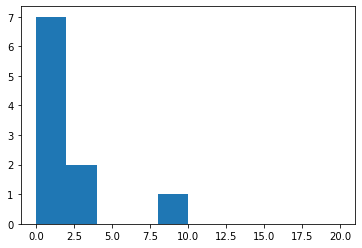

In [156]:
plt.hist(bdsf_p_to_i_sep.arcsec, range=(0, 20))

# Peak PI

We can get the peak PI map from RM synthesis (200 GB memory + 2 hours on Bracewell) and do source-finding on that. We'll use the same settings as for the P image.

The image has lots of really small spikes in it, which I'll try and remove with a simple low-pass filter.

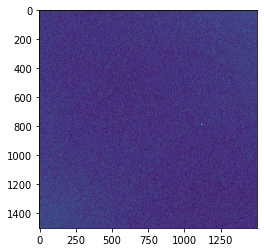

In [443]:
f = fits.open('/home/alger/possum/alger/hamburg/rmsynth_04FDF_maxPI.fits', mode='denywrite')
# plt.imshow(stretch(f[0].data[0, 1000:1050, 1000:1050]))


In [ ]:

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(3, 1, 1)
im = ax.imshow((f[0].data[0, 2600:2650, 2050:-1850]), vmax=0.1, cmap='viridis')
plt.contour(total_P[0].data[2600:2650, 2050:-1850], [0.02, 0.03], linewidths=1.5, colors='cyan')
plt.contour(total_I[2600:2650, 2050:-1850], [0.2, 0.5], linewidths=1.5, colors='white')
plt.title('Peak PI')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

ax = fig.add_subplot(3, 1, 2)
im = ax.imshow((f[0].data[0, 2600:2650, 2050:-1850]), vmax=0.01, cmap='viridis')
# plt.contour(total_P[0].data[2600:2650, 2050:-1850], [0.02, 0.03], linewidths=1.5, colors='cyan')
# plt.contour(total_I[2600:2650, 2050:-1850], [0.2, 0.5], linewidths=1.5, colors='white')
# plt.title('Peak PI')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

ax = fig.add_subplot(3, 1, 3)
im = ax.imshow((f[0].data[0, 2600:2650, 2050:-1850]), vmax=0.001, cmap='viridis')
# plt.contour(total_P[0].data[2600:2650, 2050:-1850], [0.02, 0.03], linewidths=1.5, colors='cyan')
# plt.contour(total_I[2600:2650, 2050:-1850], [0.2, 0.5], linewidths=1.5, colors='white')
# plt.title('Peak PI')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

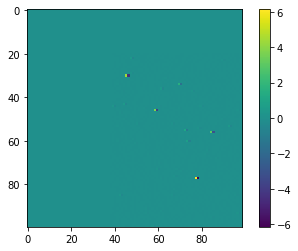

In [56]:
diffmap = numpy.diff(f[0].data[0, :100, :100])
eh = diffmap > 5
ehh = diffmap < -5
im = f[0].data[0, :100, :100].copy()
im[eh] = im[ehh]

In [49]:
mask = numpy.mgrid[0:100:1, 0:100:1]
centre = numpy.array([50, 50])[:, None, None]
fft[abs(mask - centre).sum(axis=0) < 70] = 0

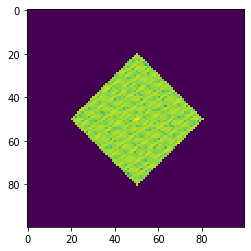

In [50]:
plt.imshow(abs(scipy.fftpack.fftshift(fft)) ** 0.1)

In [51]:
ifft = scipy.fftpack.ifft2(fft)

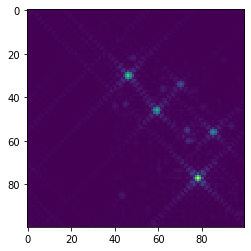

In [52]:
plt.imshow(abs(ifft))

## PyBDSF

PyBDSF refuses to process an image without frequency info, so we'll have to add that back in to the PI image.

In [7]:
new_header = Q[0].header.copy()
new_hdu = fits.PrimaryHDU(data=f[0].data[None, :, :], header=new_header)
new_hdu.writeto('/home/alger/possum/alger/hamburg/rmsynth_04FDF_maxPI_header.fits', overwrite=True)

In [12]:
img_ppi = bdsf.process_image(
    '/home/alger/possum/alger/hamburg/rmsynth_04FDF_maxPI_header.fits',
    rms_value=8*5e-3,
    thresh='hard',
    thresh_isl=3.0,
    thresh_pix=5.0,
    incl_empty=True,

    flag_maxsnr=5,
    flag_minsnr=0,
    flag_minsize_bm=0)

ERROR: Input parameter 'rms' matches to more than one possible parameter:
 rms_box
 rms_box_bright
 rms_image
 rms_map
 rms_value
 rmsmean_map_filename


RuntimeError: Input parameter 'rms' matches to more than one possible parameter:
 rms_box
 rms_box_bright
 rms_image
 rms_map
 rms_value
 rmsmean_map_filename

NOTE -- With the mouse pointer in plot window:
  Press "i" ........ : Get integrated flux densities and mean rms
                       values for the visible portion of the image
  Press "m" ........ : Change min and max scaling values
  Press "n" ........ : Show / hide island IDs
  Press "0" ........ : Reset scaling to default
  Click Gaussian ... : Print Gaussian and source IDs (zoom_rect mode, 
                       toggled with the "zoom" button and indicated in 
                       the lower right corner, must be off)
________________________________________________________________________


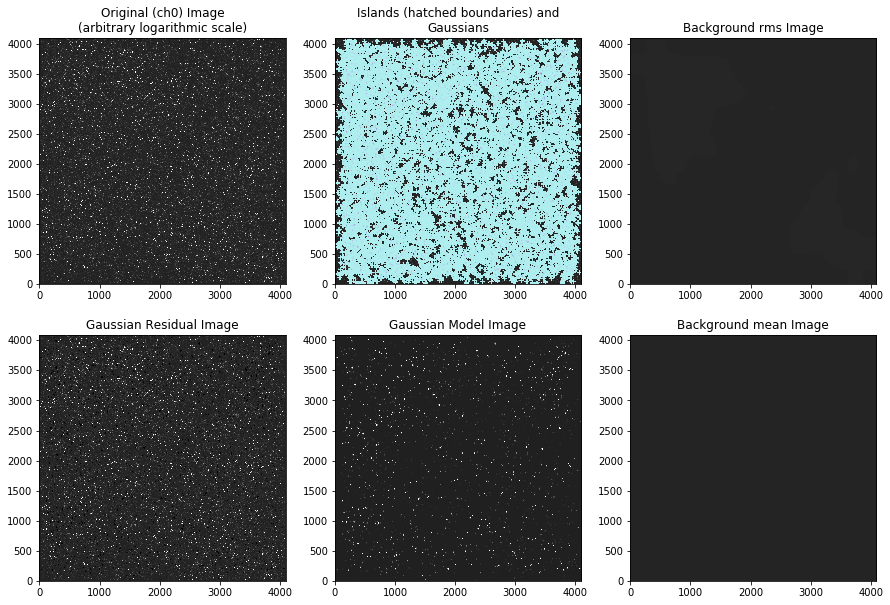

True

In [10]:
img_ppi.show_fit()

In [207]:
bbox

(slice(None, None, None), 0, slice(2716, 2743, None), slice(4052, 4075, None))

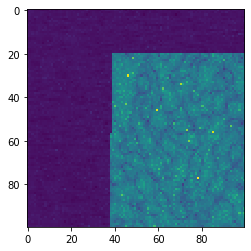

In [423]:
with fits.open('/home/alger/possum/alger/hamburg/rmsynth_04FDF_maxPI_header.fits', mode='denywrite') as f:
    plt.imshow(f[0].data[0, 0, :100, :100])